# LCPB 20-21 Exercise 5: RBM
## RandomGroup
### Alessandro Casalino 2015122
### Michele M. Crudele 2021858
### Sabrina Giorgetti 2013375
### Daniele Mellino 2013373


## Table of Contents

[Overview](#o)
1. [ Introducing a lower "temperature" in the sigmoid function](#1)
2. [ Bit correction checking](#1)
3. [Introducing new states](#3)
    1. [Introducing a fifth state "4"](#3.1)
    2. [Introducing a sixth state "5"](#3.2)

4. [Repeat the analysis with a larger error rate q=0.2](#4)
5. [Comparison of the convergence of the RBM parameters for the case SPINS= True and SPINS=False](#5)



### Function definition

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
%matplotlib inline

In [6]:
def load_data_01(q, states, SPINS=True, PRINTING=True):
    fname = f"DATA/dataRBM_q{q}_states{states}.csv"
    fname_original = f"DATA/dataRBM_states{states}_original.csv"
    
    v = np.loadtxt(fname, delimiter = ",", dtype = int)
    v_original = np.loadtxt(fname_original, delimiter = ",", dtype = int) # data before corruption # data before corruption

    N = len(v) #number of data
    L = len(v[0]) #length of samples
    
    if PRINTING:
        print(f"each of N = {N} data samples has L = {L} digits")

        for n in range(10):
            print(v[n])
        print(".....")

    if SPINS:
        vmin = -1
        GAP = 2 #gap between the two categories
        v = 2*v - 1
        v_original = 2*v_original - 1
    else:
        vmin = 0
        GAP = 1

    #store initial values
    v0 = np.copy(v)

    if PRINTING:
        for i in range(10):
            print(v[i])
        print(".....")
    
    return N, L, vmin, GAP, v_original, v0, v

In [7]:
def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np - 1.) - 0.5
    return(x, y)

def mycolor(val):
    if val > 0:
        return "red" #red for positive weights
    elif val < 0:
        return "blue" #blue for negative weights
    return "black"

def plotgraph(w, a, b, epoch, M):
    
    A = 2. / w.max()
    for i in range(L): # visible units
        for j in range(M): # hidden units
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j]) # coordinates and color
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j])) # lw proportional to the value of the weights
    
    A = 300./(a.max() + b.max())
    for i in range(L): # visible units
        plt.scatter(x1[i], y1[i], s = A * np.abs(a[i]), zorder = 2, c = mycolor(a[i])) # s = size proportional to values
    plt.title(f"> 0 red, < 0 blue, epoch = {epoch}")
    for j in range(M): # hidden units
        plt.scatter(x2[j], y2[j], s = A * np.abs(b[j]), zorder = 2, c = mycolor(b[j]))
    plt.title(f"> 0 red, < 0 blue, epoch = {epoch}")
    plt.show()
    return

In [8]:
def activate(v_in, wei, bias, DE, beta = 1, info = False,vmin=-1,GAP=2):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1 + np.exp(-DE*beta*act)) #probability to generate a 1
    n = len(act) # length of the activation
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print("input =", v_in)
        print("act =", act)
        print("prob =", prob)
        print("output =", v_out)
    return (v_out)

In [9]:
# For default value in parameters in performance()
N, L, vmin, GAP, v_original, v0, v = load_data_01(q = 0.1, states = 4, PRINTING=False)

In [10]:
def performance(v0, a, b, w, phase, bet = 1,GAP=2,vmin=-1,v_original=v_original,PRINTING=True):
    
    v1 = np.full((N, L), vmin)
    print("performance::vmin:",vmin,"GAP",GAP)
    
    if phase == 0: # no lower beta
        score = 0
        for n in range(N):
            h = activate(v0[n], w, b, GAP,vmin=vmin)
            v1[n] = activate(h, w.T, a, GAP,vmin=vmin)
            if (v1[n] == v_original[n]).all():
                score += 1
    
    elif phase == 1: # lower beta in negative phase
        score = 0
        for n in range(N):
            h = activate(v0[n], w, b, GAP,vmin=vmin)
            v1[n] = activate(h, w.T, a, GAP, beta = bet,vmin=vmin)
            if (v1[n] == v_original[n]).all():
                score += 1
            
    elif phase == 2: # lower beta in both positive and negative phases
        score = 0
        for n in range(N):
            h = activate(v0[n], w, b, GAP, beta = bet,vmin=vmin)
            v1[n] = activate(h, w.T, a, GAP, beta = bet,vmin=vmin)
            if (v1[n] == v_original[n]).all():
                score += 1 
    
    else: print("Error: phase can assume only value 0, 1 or 2")

    score = score/N
    
    if PRINTING==True:
        print("Score =",score)
        print("------------------------------------------------------------------------------")
        print("         Original                Corrupted                 Fantasy")
        print("------------------------------------------------------------------------------")
        for n in range(10):
            t = False
            if (v1[n] == v_original[n]).all():
                t = True
            print(v_original[n].astype(int), (v0[n]).astype(int), (v1[n]).astype(int), t)

        return
    return score

In [11]:
from matplotlib.ticker import MultipleLocator

bet_values = [1, 2, 3, 5, 10, 50, np.inf]
M_values = [2, 3, 4, 5, 6]

def plotgraph(w, a, b, epoch, M):
    M = int(M)
    epoch = int(epoch)

    A = 2. / w.max()
    for i in range(L): # visible units
        for j in range(M): # hidden units
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j]) # coordinates and color
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j])) # lw proportional to the value of the weights
    
    A = 300./(a.max() + b.max())
    for i in range(L): # visible units
        plt.scatter(x1[i], y1[i], s = A * np.abs(a[i]), zorder = 2, c = mycolor(a[i])) # s = size proportional to values
    plt.title(f"> 0 red, < 0 blue, epoch = {epoch}")
    for j in range(M): # hidden units
        plt.scatter(x2[j], y2[j], s = A * np.abs(b[j]), zorder = 2, c = mycolor(b[j]))
    plt.title(f"> 0 red, < 0 blue, epoch = {epoch}")
    plt.show()
    return

def calculate_score(phase, v1, bet, N, v0, w, b, GAP, a, v_original, vmin):
    score = 0
    
    if phase == 0:
        for n in range(N):
            h = activate_jit(vmin, v0[n], w, b, GAP)
            v1[n] = activate_jit(vmin, h, w.T, a, GAP)
            if (v1[n] == v_original[n]).all():
                score += 1
    elif phase == 1:
        for n in range(N):
            h = activate_jit(vmin, v0[n], w, b, GAP)
            v1[n] = activate_jit(vmin, h, w.T, a, GAP, beta = bet)
            if (v1[n] == v_original[n]).all():
                score += 1
    elif phase == 2:
        for n in range(N):
            h = activate_jit(vmin, v0[n], w, b, GAP, beta = bet)
            v1[n] = activate_jit(vmin, h, w.T, a, GAP, beta = bet)
            if (v1[n] == v_original[n]).all():
                score += 1 
    else:
        print("Error: phase value not valid")
    
    score = score/N
    return score
        

def performance_plot(phase, N, L, vmin, v0, w, b, GAP, a, v_original):
    v1 = np.full((N, L), vmin)
    score_list = []
    
    if phase == 0: # no lower beta
        score = calculate_score(phase, v1, bet, N, v0, w, b, GAP, a, v_original, vmin)
        print("Score =",score)
        return
        
    elif phase in (1,2): # 1:lower beta in negative phase, 2:lower beta in both positive and negative phases
        for bet in bet_values:
            score_list.append(calculate_score(phase, v1, bet, N, v0, w, b, GAP, a, v_original, vmin))
            
    else:
        print("Error: phase can assume only value 0, 1 or 2")
        return
    return score_list

def plot_scores(M, ax1, ax2, N, L, vmin, v0, w, b, GAP, a, v_original, PRINTING=False):
    scores_phase1 = performance_plot(1, N, L, vmin, v0, w, b, GAP, a, v_original)
    scores_phase2 = performance_plot(2, N, L, vmin, v0, w, b, GAP, a, v_original)
    if PRINTING:
        print("Scores for phase 1:")
        print(scores_phase1)
        print("Scores for phase 2:")
        print(scores_phase2)

    X = np.arange(1, len(bet_values)+1)
    ax1.plot(X, scores_phase1, label=f"M = {M}")
    ax2.plot(X, scores_phase2, label=f"M = {M}")
    
    return scores_phase1, scores_phase2
    
@njit(fastmath=True)
def activate_jit(vmin, v_in, wei, bias, DE, beta = 1, info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + np.exp(-DE*beta*act)) #probability to generate a 1
    n = len(act) # length of the activation
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print("input =", v_in)
        print("act =", act)
        print("prob =", prob)
        print("output =", v_out)
    return (v_out)

@njit(fastmath=True)
def RBM_train_jit(vmin, GAP, N, L, M, v, l_rate = 1.0, mini = 500, m = 0, nepoch = 50, PRINTING=False):
    
    np.random.seed(12345)
    
    # initialization
    sigma = np.sqrt(4./float(L + M))
    w = sigma * (2*np.random.rand(L, M) - 1)
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)
    
    # We need to return these matrices to plot outside a njit Numba function
    size_plot = nepoch // 5
    w_plot = np.zeros((size_plot,)+w.shape)
    a_plot = np.zeros((size_plot,)+a.shape)
    b_plot = np.zeros((size_plot,)+b.shape)
    epoch_plot = np.zeros(size_plot)
    M_plot = np.zeros(size_plot)
    
    np.random.seed(12345)
    
    for epoch in range(1, 1+nepoch):
        for n in range(N):
            if m == 0:
                # initialize
                #average of v according to the data and the model
                v_data, v_model = np.zeros(L), np.zeros(L)
                #average of h according to the data and the model
                h_data, h_model = np.zeros(M), np.zeros(M)
                #average of vh according to the data and the model
                vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))

            # positive CD phase
            h = activate_jit(vmin, v[n], w, b, GAP)
            # negative CD phase
            vf = activate_jit(vmin, h, w.T, a, GAP)
            # positive CD phase nr 2
            hf = activate_jit(vmin, vf, w, b, GAP)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1

            # gradient descent
            if m == mini:
                C = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C*(h_data - h_model)

                if epoch <= 2 and n <= mini and PRINTING==True:
                    print("------ epoch =", epoch, "  n =", n, "  m =", m)
                    print("dw =", dw)
                    print("da =", da)
                    print("db =", db)

                w += dw
                a += da
                b += db

                m = 0

        # randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)
        if epoch%5 == 0:
            counter = epoch//5 - 1
            w_plot[counter] = w
            a_plot[counter] = a
            b_plot[counter] = b
            epoch_plot[counter] = epoch
            M_plot[counter] = M
            # plotgraph(w, a, b, epoch, M)
            if PRINTING==True:
                print("l_rate", l_rate)
            
    return a, b, w, w_plot, a_plot, b_plot, epoch_plot, M_plot

@njit(fastmath=True)
def RBM_train_gauss_jit(vmin, GAP, N, L, M, v, l_rate = 1.0, mini = 500, m = 0, nepoch = 50, PRINTING=False):
    
    np.random.seed(12345)
    
    # initialization
    sigma = np.sqrt(4./float(L + M))
    w = sigma * (2*np.random.normal(0., 2/(L+M)**0.5, (L, M)) - 1.)
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)
    
    # We need to return these matrices to plot outside a njit Numba function
    size_plot = nepoch // 5
    w_plot = np.zeros((size_plot,)+w.shape)
    a_plot = np.zeros((size_plot,)+a.shape)
    b_plot = np.zeros((size_plot,)+b.shape)
    epoch_plot = np.zeros(size_plot)
    M_plot = np.zeros(size_plot)
    
    np.random.seed(12345)
    
    for epoch in range(1, 1+nepoch):
        for n in range(N):
            if m == 0:
                # initialize
                #average of v according to the data and the model
                v_data, v_model = np.zeros(L), np.zeros(L)
                #average of h according to the data and the model
                h_data, h_model = np.zeros(M), np.zeros(M)
                #average of vh according to the data and the model
                vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))

            # positive CD phase
            h = activate_jit(vmin, v[n], w, b, GAP)
            # negative CD phase
            vf = activate_jit(vmin, h, w.T, a, GAP)
            # positive CD phase nr 2
            hf = activate_jit(vmin, vf, w, b, GAP)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1

            # gradient descent
            if m == mini:
                C = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C*(h_data - h_model)

                if epoch <= 2 and n <= mini and PRINTING==True:
                    print("------ epoch =", epoch, "  n =", n, "  m =", m)
                    print("dw =", dw)
                    print("da =", da)
                    print("db =", db)

                w += dw
                a += da
                b += db

                m = 0

        # randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)
        if epoch%5 == 0:
            counter = epoch//5 - 1
            w_plot[counter] = w
            a_plot[counter] = a
            b_plot[counter] = b
            epoch_plot[counter] = epoch
            M_plot[counter] = M
            # plotgraph(w, a, b, epoch, M)
            if PRINTING==True:
                print("l_rate", l_rate)
            
    return a, b, w, w_plot, a_plot, b_plot, epoch_plot, M_plot

def plot_scores_M(q, states, PRINTING=False, SPINS=True):
    with plt.style.context("seaborn"):
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
    score1_min, score1_max, score2_min, score2_max = 1, 0, 1, 0
    
    for i,M in enumerate(M_values):
        N, L, vmin, GAP, v_original, v0, v = load_data_01(q=q, states=states, PRINTING=False, SPINS=SPINS)
        
        if PRINTING:
            print(f"M = {M}")
        (x1, y1) = create_coord(L, 0) #visible units
        (x2, y2) = create_coord(M, 1) #hidden units

        # We must use the same type for operation in njit (i.e. float)
        v = v.astype(float)
        vmin = float(vmin)
        a, b, w, _, _, _, _, _ = RBM_train_jit(vmin, GAP, N, L, M, v, PRINTING=PRINTING)
        
        v0 = v0.astype(float)
        w = w.astype(float)
        scores_phase1, scores_phase2 = plot_scores(M, ax1, ax2, N, L, vmin, v0, w, b, GAP, a, v_original, PRINTING)
        score1_min = min(scores_phase1 + [score1_min])
        score1_max = max(scores_phase1 + [score1_max])
        score2_min = min(scores_phase2 + [score2_min])
        score2_max = max(scores_phase2 + [score2_max])
    
    fig.suptitle(f"#N states = {states}, q = {q}", fontsize=16)
    # For ticks on x axis
    X = np.arange(1, len(bet_values)+1)
    ax1.set_title(f"SPIN = {SPINS}, lower temperature only in negative phase")
    ax2.set_title(f"SPIN = {SPINS}, lower temperature in both phases")
    # We limit the ticks on y-axis for visualization purpose
    ax1.set_yticks([score1_min, score1_max])
    ax2.set_yticks([score2_min, score2_max])
    # We limit digits to visualize to 3
    ax1.set_yticklabels("{:.3f}".format(x) for x in [score1_min, score1_max])
    ax2.set_yticklabels("{:.3f}".format(x) for x in [score2_min, score2_max])
    # Layout similiar for the two plots
    for ax in (ax1, ax2):
        ax.set_xticks(X)
        ax.set_xticklabels(bet_values)
        ax.yaxis.set_minor_locator(MultipleLocator(0.01))
        ax.set_xlabel("$beta$")
        ax.set_ylabel("score")
        ax.set_ylim([0, 1])
        ax.legend()
        
def plot_scores_M_gauss(q, states, PRINTING=False, SPINS=True):
    with plt.style.context("seaborn"):
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
    score1_min, score1_max, score2_min, score2_max = 1, 0, 1, 0
    
    for i,M in enumerate(M_values):
        N, L, vmin, GAP, v_original, v0, v = load_data_01(q=q, states=states, PRINTING=False, SPINS=SPINS)
        
        if PRINTING:
            print(f"M = {M}")
        (x1, y1) = create_coord(L, 0) #visible units
        (x2, y2) = create_coord(M, 1) #hidden units

        # We must use the same type for operation in njit (i.e. float)
        v = v.astype(float)
        vmin = float(vmin)
        a, b, w, _, _, _, _, _ = RBM_train_gauss_jit(vmin, GAP, N, L, M, v, PRINTING=PRINTING)
        
        v0 = v0.astype(float)
        w = w.astype(float)
        scores_phase1, scores_phase2 = plot_scores(M, ax1, ax2, N, L, vmin, v0, w, b, GAP, a, v_original, PRINTING)
        score1_min = min(scores_phase1 + [score1_min])
        score1_max = max(scores_phase1 + [score1_max])
        score2_min = min(scores_phase2 + [score2_min])
        score2_max = max(scores_phase2 + [score2_max])
    
    fig.suptitle(f"#N states = {states}, q = {q}", fontsize=16)
    # For ticks on x axis
    X = np.arange(1, len(bet_values)+1)
    ax1.set_title(f"SPIN = {SPINS}, lower temperature only in negative phase")
    ax2.set_title(f"SPIN = {SPINS}, lower temperature in both phases")
    # We limit the ticks on y-axis for visualization purpose
    ax1.set_yticks([score1_min, score1_max])
    ax2.set_yticks([score2_min, score2_max])
    # We limit digits to visualize to 3
    ax1.set_yticklabels("{:.3f}".format(x) for x in [score1_min, score1_max])
    ax2.set_yticklabels("{:.3f}".format(x) for x in [score2_min, score2_max])
    # Layout similiar for the two plots
    for ax in (ax1, ax2):
        ax.set_xticks(X)
        ax.set_xticklabels(bet_values)
        ax.yaxis.set_minor_locator(MultipleLocator(0.01))
        ax.set_xlabel("$beta$")
        ax.set_ylabel("score")
        ax.set_ylim([0, 1])
        ax.legend()

### Function to compare the scores in the cases SPIN = True and SPIN = False

In [9]:
def plot_best_M(q):
    with plt.style.context("seaborn"):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,6*2))

    for i, states in enumerate((4, 5, 6)):
        for SPINS in (True, False):
            # Choosing M values list according to the values of q and SPINS
            if (q, SPINS) == (0.1, True):
                M = M_q1_spinTrue[i]
            elif (q, SPINS) == (0.2, True):
                M = M_q2_spinTrue[i]
            elif (q, SPINS) == (0.1, False):
                M = M_q1_spinFalse[i]
            elif (q, SPINS) == (0.2, False):
                M = M_q2_spinFalse[i]
            else:
                print(f"ERROR: pair q = {q}, SPINS = {SPINS} not valid")
                return
            # Loading files
            N, L, vmin, GAP, v_original, v0, v = load_data_01(q=q, states=states, PRINTING=False, SPINS=SPINS)

            # We must use the same type for operation in njit (i.e. float)
            v = v.astype(float)
            vmin = float(vmin)
            # Training
            a, b, w, _, _, _, _, _ = RBM_train_jit(vmin, GAP, N, L, M, v, PRINTING=False)

            # Plotting 
            if SPINS == True:
                ax1, ax2 = ax[0,0], ax[1,0]
            else:
                ax1, ax2 = ax[0,1], ax[1,1]
            v0 = v0.astype(float)
            w = w.astype(float)
            scores_phase1 = performance_plot(1, N, L, vmin, v0, w, b, GAP, a, v_original)
            scores_phase2 = performance_plot(2, N, L, vmin, v0, w, b, GAP, a, v_original)
            
            X = np.arange(1, len(bet_values)+1)
            ax1.plot(X, scores_phase1, label=f"#N states = {states}")
            ax2.plot(X, scores_phase2, label=f"#N states = {states}")
            
            ax1.set_title(f"SPINS = {SPINS}, lower temperature only in negative phase")
            ax2.set_title(f"SPINS = {SPINS}, lower temperature in both phases")


    fig.suptitle(f"q = {q}", fontsize=16)
    # For ticks on x axis
    X = np.arange(1, len(bet_values)+1)
    # Layout similiar for the plots
    for ax in (ax[0,0], ax[0,1], ax[1,0], ax[1,1]):
        ax.set_xticks(X)
        ax.set_xticklabels(bet_values)
        ax.yaxis.set_minor_locator(MultipleLocator(0.01))
        ax.set_xlabel("$beta$")
        ax.set_ylabel("score")
        ax.set_ylim([0, 1])
        ax.legend()

### Functions to plot

In [10]:
@njit(fastmath=True)
def RBM_train2_jit(vmin, GAP, N, L, M, v, l_rate = 1.0, mini = 500, m = 0, nepoch = 50, PRINTING=False,STORE_w=False,seed=12345):

    np.random.seed(seed)
    
    # initialization
    sigma = np.sqrt(4./float(L + M))
    w = sigma * (2*np.random.rand(L, M) - 1)
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)
    
    dim=N/mini*nepoch
    store_w=np.zeros((int(dim),L,M) ) # per punto 5
    #store_counter=np.zeros((int(dim),2 )) #5   
    np.random.seed(seed)
    counter=0
    for epoch in range(1, 1+nepoch):
        #counter_m=0 # 5

        for n in range(N):
            if m == 0:
                # initialize
                #average of v according to the data and the model
                v_data, v_model = np.zeros(L), np.zeros(L)
                #average of h according to the data and the model
                h_data, h_model = np.zeros(M), np.zeros(M)
                #average of vh according to the data and the model
                vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))

            # positive CD phase
            h = activate_jit(vmin, v[n], w, b, GAP)
            # negative CD phase
            vf = activate_jit(vmin, h, w.T, a, GAP)
            # positive CD phase nr 2
            hf = activate_jit(vmin, vf, w, b, GAP)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1

            # gradient descent
            if m == mini:
                C = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C*(h_data - h_model)

                if epoch <= 2 and n <= mini and PRINTING==True:
                    print("------ epoch =", epoch, "  n =", n, "  m =", m)
                    print("dw =", dw)
                    print("da =", da)
                    print("db =", db)
                
                if STORE_w:
                    #print(dw)
                    store_w[counter,:,:]=dw
                    #print(store_w[counter,:,:])

                    counter=counter+1

                w += dw
                a += da
                b += db

                m = 0
        #print(counter)
        # randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)
        if epoch%5 == 0 and PRINTING==True: 
            # plotgraph(w, a, b, epoch, M)
            print("l_rate", l_rate)

    return a, b, w,store_w#,store_counter

def plot_dw2(q,M,states) :
    with plt.style.context("seaborn"):
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
        
    
    N, L, vmin, GAP, v_original1, v01, v = load_data_01(q=q, states=states, PRINTING=False, SPINS=True)
    N2, L2, vmin2, GAP2, v_original2, v02, v2 = load_data_01(q=q, states=states, PRINTING=False, SPINS=False)

    v = v.astype(float)
    vmin = float(vmin)
    
    v2 = v2.astype(float)
    vmin2 = float(vmin2)
    
    a1, b1, w1, dw_array_1= RBM_train2_jit(vmin, GAP, N, L, M, v, PRINTING=False,STORE_w=True)
    a2, b2, w2, dw_array_2= RBM_train2_jit(vmin2, GAP2, N2, L2, M, v2, PRINTING=False,STORE_w=True)

    #index =index.astype(int)

    dw_pm1=np.zeros(dw_array_1.shape[0] )
    for i in range(len(dw_array_1)):
        dw_pm1[i]=(np.sum(np.multiply(dw_array_1[i,:,:],dw_array_1[i,:,:]) )/L/M ) 
        
    
    dw_pm2=np.zeros(dw_array_2.shape[0] )
    for i in range(len(dw_array_2)):
        dw_pm2[i]=(np.sum(np.multiply(dw_array_2[i,:,:],dw_array_2[i,:,:]) )/L2/M ) 
        
    

    epoch=np.arange(1,50)
    minibatch=np.arange(0,len(dw_array_1))
    #print(index)
    ax1.plot(epoch,dw_pm1[(epoch-1)*20],alpha=0.8,color="blue", label="SPINS=True")
    ax1.plot(epoch,dw_pm2[(epoch-1)*20],alpha=0.8,color="red",label="SPINS=False")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel(r"$\langle  dw^2 \rangle$")
    ax1.legend()
    
    ax2.set_ylim(0, 0.02)
    ax2.plot(minibatch, dw_pm1,alpha=0.8,color="blue", label="SPINS=True")
    ax2.plot(minibatch, dw_pm2,alpha=0.8,color="red",label="SPINS=False")
    ax2.set_xlabel("minibatch")
    ax2.set_ylabel(r"$\langle  dw^2 \rangle$")
    ax2.legend()

    fig.suptitle(r"Mean square increment $\langle  dw^2 \rangle$ of weights versus time for M= "+str(M)+", q= "+str(q)+" and "+str(states)+" states.", fontsize=16)


def plot_dseed(q,M,states):
    with plt.style.context("seaborn"):
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
        
    
    N, L, vmin, GAP, v_original1, v01, v = load_data_01(q=q, states=states, PRINTING=False, SPINS=True)
    N2, L2, vmin2, GAP2, v_original2, v02, v2 = load_data_01(q=q, states=states, PRINTING=False, SPINS=False)
    
    v = v.astype(float)
    vmin = float(vmin)
    
    v2 = v2.astype(float)
    vmin2 = float(vmin2)
    
    seeds=np.array([67543,588748,8753983,670554,838104,1454910])
    for seed in seeds:
        a1, b1, w1, _= RBM_train2_jit(vmin, GAP, N, L, M, v, PRINTING=False,seed=seed)
        a2, b2, w2, _= RBM_train2_jit(vmin2, GAP2, N2, L2, M, v2, PRINTING=False,seed=seed)
        
        v01 = v01.astype(float)
        w1 = w1.astype(float)
        
        v02 = v02.astype(float)
        w2 = w2.astype(float)

        scores_phase1 = performance_plot(2, N, L, vmin, v01, w1, b1, GAP, a1, v_original1)
        scores_phase2 = performance_plot(2, N2, L2, vmin2, v02, w2, b2, GAP2, a2, v_original2)
        
        X = np.arange(1, len(bet_values)+1)
        ax1.plot(X, scores_phase1, label=str(seed))
        # We limit the ticks on y-axis for visualization purpose
    #     yticks1 = [scores_phase1[i] for i in [0, 1, -1]]
    #     ax1.set_yticks(yticks1)
        
        ax2.plot(X, scores_phase2, label=str(seed))
        fig.suptitle(f"Scores for different seeds with M = {M}, q = {q} and {states} states.", fontsize=16)
        ax1.set_title("SPINS=True")
        ax2.set_title("SPINS=False")
        for ax in (ax1, ax2):
            ax.set_xticks(X)
            ax.set_xticklabels(bet_values)
            ax.yaxis.set_minor_locator(MultipleLocator(0.01))
            ax.set_xlabel("$beta$")
            ax.set_ylabel("score")
            ax.set_ylim([0, 1])

            ax.legend(title="Seeds:")

### Function to plot confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def conf_matrix(v0,a,b,w,phase,bet=1,GAP=2,vmin=-1,v_original=v_original):

    v1 = np.full((N, L), vmin)
    v2= np.full(N,-1 )
    v2or=np.full(N,-1 )
    labels_vector = np.unique(v_original, axis=0)

    for n in range(N):
        if phase == 0: # no lower beta
            h = activate(v0[n], w, b, GAP,vmin=vmin)
            v1[n] = activate(h, w.T, a, GAP,vmin=vmin)
        
        elif phase == 1: 
            h = activate(v0[n], w, b, GAP,vmin=vmin)
            v1[n] = activate(h, w.T, a, GAP, beta = bet,vmin=vmin)
        elif phase==2:
            h = activate(v0[n], w, b, GAP, beta = bet,vmin=vmin)
            v1[n] = activate(h, w.T, a, GAP, beta = bet,vmin=vmin)
            
        for j in range(len(labels_vector) ):
            if (v1[n] == labels_vector[j]).all():
                v2[n]=j
            if(v_original[n]==labels_vector[j]).all():
                v2or[n]=j
                
    #print(labels_vector )
    confi=confusion_matrix(v2or, v2) / N
    
#     disp = ConfusionMatrixDisplay(
#         confusion_matrix=confi,
#         display_labels=np.arange(-1,len(confi)-1)
#     )
    #print(v2or)
    fig = plt.figure(figsize=(10, 8))
    if len(confi) == 4:
        labels = np.arange(0,len(confi))
    else:
        labels = np.arange(-1,len(confi)-1)
    sns.heatmap(confi, annot=True, fmt='.2%', linewidth=1, cmap="viridis",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.yticks(rotation=0)
#     disp.plot()

### Load data and RBM training

each of N = 10000 data samples has L = 8 digits
[1 1 0 0 1 1 0 0]
[1 1 0 0 0 1 1 0]
[0 1 0 1 1 1 0 0]
[0 0 1 1 0 0 1 1]
[0 1 0 0 0 0 1 1]
[0 1 1 1 0 0 1 1]
[1 1 0 0 0 1 1 1]
[0 1 0 0 0 0 1 1]
[0 0 1 1 1 1 1 0]
[1 1 0 0 1 1 1 0]
.....
[ 1  1 -1 -1  1  1 -1 -1]
[ 1  1 -1 -1 -1  1  1 -1]
[-1  1 -1  1  1  1 -1 -1]
[-1 -1  1  1 -1 -1  1  1]
[-1  1 -1 -1 -1 -1  1  1]
[-1  1  1  1 -1 -1  1  1]
[ 1  1 -1 -1 -1  1  1  1]
[-1  1 -1 -1 -1 -1  1  1]
[-1 -1  1  1  1  1  1 -1]
[ 1  1 -1 -1  1  1  1 -1]
.....
------ epoch = 1   n = 499   m = 500
dw = [[-0.304 -0.236 -0.364]
 [ 0.052 -0.184 -0.44 ]
 [-0.268  0.064  0.328]
 [-0.1    0.096  0.176]
 [-0.012  0.296  0.4  ]
 [-0.7   -0.56  -0.304]
 [-0.084 -0.152 -0.328]
 [ 0.272  0.228  0.044]]
da = [ 0.064 -0.244 -0.316 -0.204 -0.188  0.244  0.348 -0.32 ]
db = [0.008 0.172 0.052]
------ epoch = 2   n = 499   m = 500
dw = [[ 0.07619048  0.00380952  0.01142857]
 [-0.01904762  0.03047619  0.        ]
 [-0.06095238 -0.08761905 -0.04952381]
 [ 0.0152381   0.0

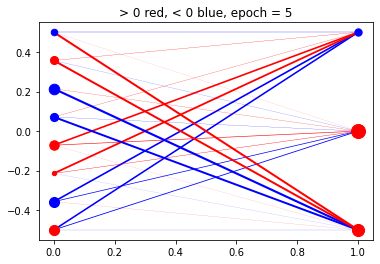

[[-0.02088504 -0.4955724  -0.77029945]
 [ 0.03010964 -0.46620238 -0.96020379]
 [-0.02230321  0.23124325  0.99932333]
 [ 0.08150112  0.2649406   0.92522566]
 [-1.14535005 -0.00651563  0.00983197]
 [-1.19761736  0.01723584 -0.10045097]
 [ 1.11700879  0.01370992  0.02030929]
 [ 1.10093505  0.14523596 -0.23968017]] [ 0.1122544   0.07878943  0.01772858 -0.01149478  0.00829783  0.00358376
 -0.05387298  0.02996773] [ 0.0833557   0.32100487 -0.01611922] 10.0 3.0


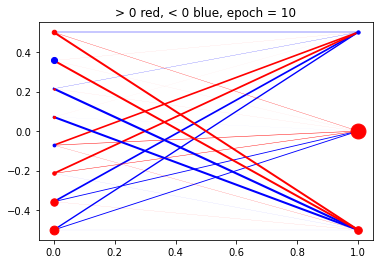

[[-4.50690154e-02 -4.01724434e-01 -9.23146528e-01]
 [-2.40955812e-02 -1.89055781e-01 -1.02438796e+00]
 [ 1.18097224e-02  4.62385050e-02  1.05174131e+00]
 [-9.89992808e-04  3.07022796e-01  9.11419492e-01]
 [-1.09358469e+00  1.75336993e-01  8.13838337e-02]
 [-1.13586180e+00  2.19529409e-01 -4.02585161e-02]
 [ 1.10197262e+00 -1.70768631e-01  1.15782635e-01]
 [ 1.14135601e+00  7.46749526e-02 -2.09846922e-01]] [ 0.01304892 -0.00104704  0.02372087  0.02138688 -0.08094606 -0.02936029
  0.03198781 -0.0295066 ] [ 0.03571664  0.16873051 -0.08857124] 15.0 3.0


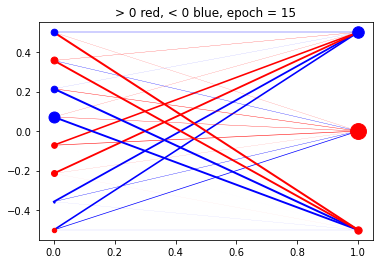

[[ 3.29376993e-02 -5.32728021e-01 -8.77150526e-01]
 [ 2.74910847e-02 -1.15262302e-01 -1.04387093e+00]
 [-1.84676114e-03  2.30126194e-01  9.23003012e-01]
 [ 2.19944468e-02  1.09576241e-01  9.83700034e-01]
 [-1.11064015e+00 -1.66679178e-04  3.76999531e-02]
 [-1.13964656e+00  8.56101480e-02 -6.43480816e-02]
 [ 1.08074809e+00 -5.14893652e-02  3.76540915e-02]
 [ 1.12733264e+00  1.51615301e-01 -1.15289642e-01]] [ 0.1243257   0.01799795 -0.08182474  0.0043484  -0.0238694  -0.0483431
  0.02219439 -0.00601194] [-0.03287761  0.31456387 -0.07319173] 20.0 3.0


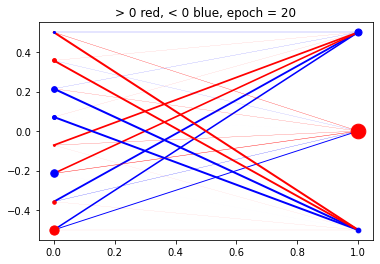

[[ 0.07708416 -0.36434803 -1.03301103]
 [-0.02250159 -0.07446599 -1.10026431]
 [ 0.03713873  0.12089649  1.00146414]
 [ 0.07131444 -0.00449539  1.06587168]
 [-1.12089246 -0.16185365  0.03333503]
 [-1.1200761  -0.16302674  0.04774165]
 [ 1.06710389 -0.14043069  0.04538937]
 [ 1.08979778  0.14362731 -0.12376001]] [ 0.20617243 -0.00790271 -0.04246274 -0.01146778  0.06913365 -0.00053679
  0.06229224 -0.06049494] [-0.09321596  0.67903155  0.02439747] 25.0 3.0


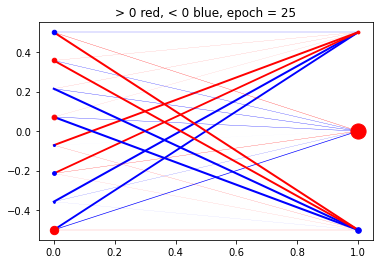

[[ 2.22137124e-02 -2.13196130e-01 -1.12259615e+00]
 [-1.85287976e-02  2.37900966e-04 -1.10267167e+00]
 [ 6.20926128e-03  1.58441686e-02  1.07552594e+00]
 [ 1.22475295e-01 -1.21873001e-01  1.08480372e+00]
 [-1.06146956e+00 -2.43606738e-01  6.97794557e-02]
 [-1.10090589e+00 -8.19358678e-02 -4.18051368e-02]
 [ 1.10374948e+00 -1.40527881e-01  9.83862104e-03]
 [ 1.05214528e+00  1.21401765e-01 -6.55260512e-02]] [ 0.1332082  -0.02770634  0.06594671  0.12941854  0.13539856  0.00025774
  0.08800539 -0.04917996] [-0.04476169  0.79677053  0.03085314] 30.0 3.0


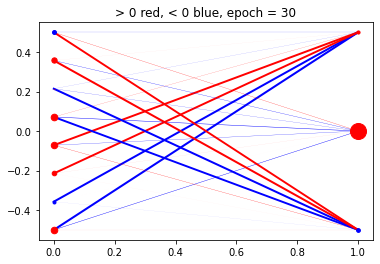

[[-0.01997831 -0.08518092 -1.09997048]
 [ 0.02237912  0.06040575 -1.1054898 ]
 [-0.0140652   0.04080003  1.12140166]
 [ 0.02306815 -0.0580969   1.04562712]
 [-1.0920541  -0.19675517 -0.00323646]
 [-1.14767262  0.00700506 -0.02250407]
 [ 1.06753086  0.07120302  0.03739748]
 [ 1.11077815  0.07282709 -0.03936623]] [ 0.06165868  0.02879366 -0.02968807  0.04014634  0.16231368 -0.03238854
 -0.00691331 -0.07278682] [-0.01863885  1.04524133  0.03198075] 35.0 3.0


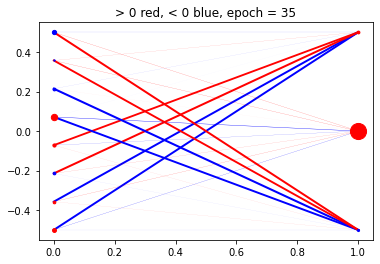

[[ 0.01460688 -0.0298111  -1.06747136]
 [ 0.007744    0.0552734  -1.15457654]
 [ 0.0285021  -0.06994751  1.08479036]
 [ 0.02116771 -0.01972495  1.07816806]
 [-1.04264374 -0.37118139 -0.01760119]
 [-1.12906888  0.05204285  0.02953163]
 [ 1.02581328  0.06739473  0.05819865]
 [ 1.07725909  0.15021429 -0.01186645]] [ 0.00266342 -0.02621259  0.05349182  0.03298655  0.22273456 -0.02581143
 -0.09442331 -0.11830748] [0.0249308  0.94454835 0.02150556] 40.0 3.0


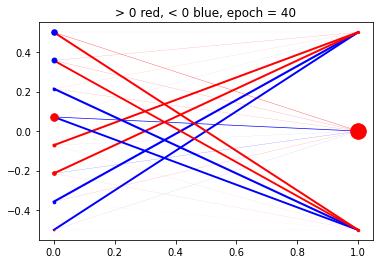

[[ 0.06901248  0.0116781  -1.06573475]
 [ 0.04927815 -0.0210035  -1.12409312]
 [-0.04033742  0.04256114  1.14110415]
 [ 0.02964519 -0.06046061  1.06484829]
 [-1.06903553 -0.227298    0.0202722 ]
 [-1.16524339  0.06595142 -0.01927144]
 [ 1.0066572   0.13891164  0.02498695]
 [ 1.07735522  0.15078092  0.00929443]] [ 0.03716366  0.06522451 -0.0248466   0.05081216  0.20049715 -0.02780104
 -0.12974818 -0.14482399] [ 0.00132621  1.07467448 -0.0206347 ] 45.0 3.0


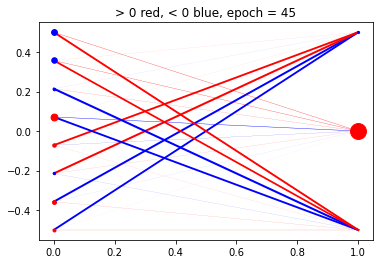

[[ 2.04792352e-04  1.09405721e-01 -1.04310805e+00]
 [ 3.83605186e-02 -1.07473104e-01 -1.11173785e+00]
 [-5.20137163e-02  7.67559065e-02  1.11158734e+00]
 [ 6.98894902e-02  3.59488697e-02  1.09031422e+00]
 [-1.01860504e+00 -3.32980204e-01  4.76764583e-02]
 [-1.13473993e+00 -9.83850923e-03 -1.29945278e-02]
 [ 9.84947138e-01  2.29075048e-01 -8.88542290e-03]
 [ 1.02862779e+00  1.40303440e-01 -1.12788383e-02]] [-0.02817613  0.05722185 -0.02088455 -0.03040714  0.23596947 -0.02800688
 -0.126318   -0.11687394] [-0.01529054  0.92708226 -0.00166824] 50.0 3.0


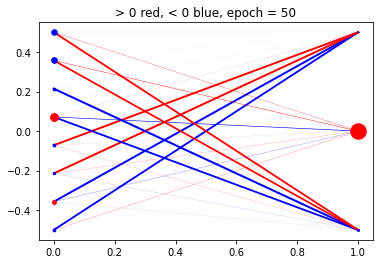

In [12]:
N, L, vmin, GAP, v_original, v0, v = load_data_01(q = 0.1, states = 4, PRINTING=True, SPINS=True)

M = 3

(x1, y1) = create_coord(L, 0) #visible units
(x2, y2) = create_coord(M, 1) #hidden units

v = v.astype(float)
vmin = float(vmin)
a, b, w, w_plot, a_plot, b_plot, epoch_plot, M_plot = RBM_train_jit(vmin, GAP, N, L, M, v, PRINTING=True)

for i in range(w_plot.shape[0]):
    print(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])
    plotgraph(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])

### Beta = 1

performance::vmin: -1 GAP 2
Score = 0.3926
------------------------------------------------------------------------------
         Original                Corrupted                 Fantasy
------------------------------------------------------------------------------
[ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] True
[ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1 -1  1  1 -1] [ 1  1 -1  1  1  1 -1 -1] False
[ 1  1 -1 -1  1  1 -1 -1] [-1  1 -1  1  1  1 -1 -1] [ 1  1  1 -1  1  1 -1 -1] False
[-1 -1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [-1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[-1 -1  1  1 -1 -1  1  1] [-1  1  1  1 -1 -1  1  1] [-1 -1 -1  1  1 -1  1  1] False
[ 1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1  1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [-1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[-1 -1  1  1  1  1 -1 -1] [-1 -1  1  1  1  1  1 -1] [-1 -1  1  1 

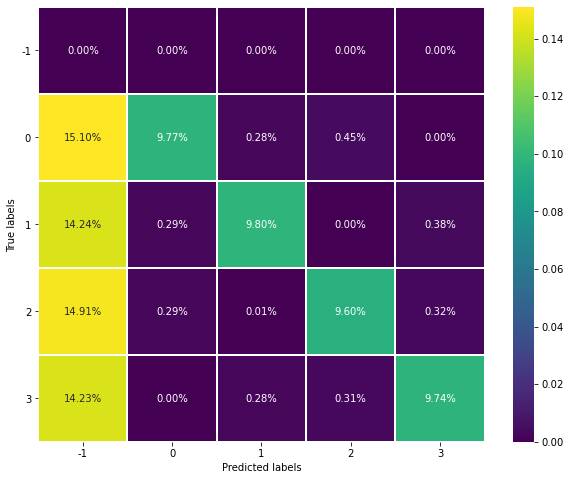

In [13]:
performance(v0, a, b, w, phase = 0,v_original=v_original)
conf_matrix(v0, a, b, w, phase=0, bet=1, GAP=2, vmin=-1, v_original=v_original)

<a name="1"></a> <a name="2"></a>
# 1-2.  Introducing a lower "temperature" in the sigmoid function and bit correction checking 

After the RBM has been trained, introduce a lower “temperature” in the sigmoid function
(higher β) to generate the visible fantasy data from the hidden layer. Eventually introduce this
choice also for the positive phase generating the hidden units.

Assess whether bit correction is working: generate a file the data before corruption and compare
them with the corresponding fantasy data from RMB, generated either normally or with a high
β as in point 1.



### Case for lower temperature in negative phase

performance::vmin: -1 GAP 2
Score = 0.8329
------------------------------------------------------------------------------
         Original                Corrupted                 Fantasy
------------------------------------------------------------------------------
[ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] True
[ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1 -1  1  1 -1] [ 1  1 -1 -1  1  1 -1 -1] True
[ 1  1 -1 -1  1  1 -1 -1] [-1  1 -1  1  1  1 -1 -1] [-1 -1  1  1  1  1 -1 -1] False
[-1 -1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [-1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[-1 -1  1  1 -1 -1  1  1] [-1  1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1  1  1  1] [ 1  1 -1 -1  1  1 -1 -1] False
[ 1  1 -1 -1 -1 -1  1  1] [-1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[-1 -1  1  1  1  1 -1 -1] [-1 -1  1  1  1  1  1 -1] [-1 -1  1  1  

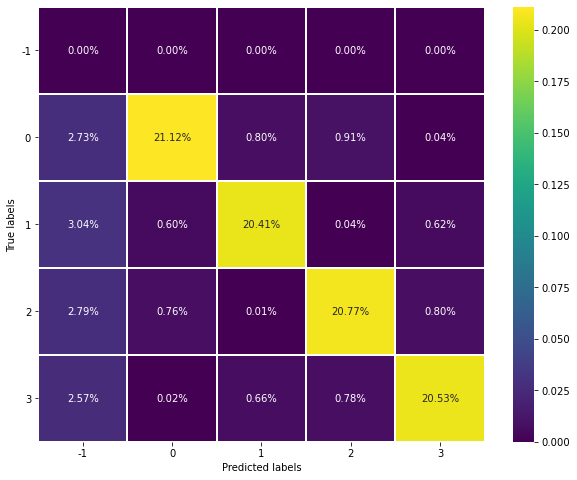

In [14]:
performance(v0, a, b, w, phase = 1, bet = 2,v_original=v_original)
conf_matrix(v0, a, b, w, phase=1, bet=2, GAP=2, vmin=-1, v_original=v_original)

### Case for lower temperature in both negative and positive phases

performance::vmin: -1 GAP 2
Score = 0.8432
------------------------------------------------------------------------------
         Original                Corrupted                 Fantasy
------------------------------------------------------------------------------
[ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] True
[ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1 -1  1  1 -1] [-1  1 -1 -1  1  1 -1 -1] False
[ 1  1 -1 -1  1  1 -1 -1] [-1  1 -1  1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] True
[-1 -1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [-1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[-1 -1  1  1 -1 -1  1  1] [-1  1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1  1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [-1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[-1 -1  1  1  1  1 -1 -1] [-1 -1  1  1  1  1  1 -1] [-1 -1  1  1  1

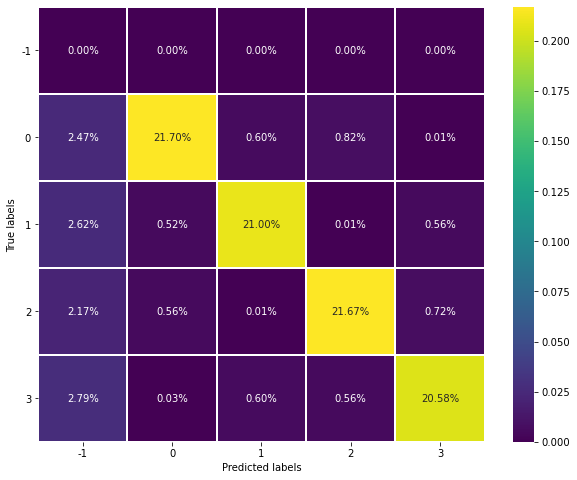

In [15]:
performance(v0, a, b, w, phase = 2, bet = 2,v_original=v_original)
conf_matrix(v0, a, b, w, phase=2, bet=2, GAP=2, vmin=-1, v_original=v_original)

### Deterministic case

performance::vmin: -1 GAP 2
Score = 0.9402
------------------------------------------------------------------------------
         Original                Corrupted                 Fantasy
------------------------------------------------------------------------------
[ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] True
[ 1  1 -1 -1  1  1 -1 -1] [ 1  1 -1 -1 -1  1  1 -1] [ 1  1 -1 -1  1  1 -1 -1] True
[ 1  1 -1 -1  1  1 -1 -1] [-1  1 -1  1  1  1 -1 -1] [ 1  1 -1 -1  1  1 -1 -1] True
[-1 -1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [-1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[-1 -1  1  1 -1 -1  1  1] [-1  1  1  1 -1 -1  1  1] [-1 -1  1  1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1  1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[ 1  1 -1 -1 -1 -1  1  1] [-1  1 -1 -1 -1 -1  1  1] [ 1  1 -1 -1 -1 -1  1  1] True
[-1 -1  1  1  1  1 -1 -1] [-1 -1  1  1  1  1  1 -1] [-1 -1  1  1  1 

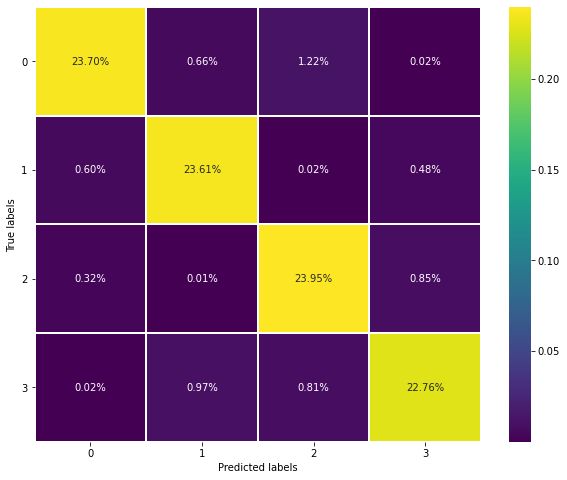

In [16]:
performance(v0, a, b, w, phase = 2, bet = np.inf,v_original=v_original)
conf_matrix(v0, a, b, w, phase=2, bet=np.inf, GAP=2, vmin=-1, v_original=v_original)

# 3. Introducing new states <a name="3"></a>

Introduce a fifth state “4” (see table below) and check which is the minimum number of hidden
units M for the RBM to work properly. Eventually repeat this also when a sixth state “5” is
introduced.

|label|state|
| --- | ---|
| 0 | 11001100 |
| 1 | 00111100 |
| 2 | 11000011 |
| 3 | 00110011 |
| 4 | 11111111 | 
| 5 | 10101000 |

### Introducing a fifth state "4" <a name="3.1"></a>

each of N = 10000 data samples has L = 8 digits
[1 1 0 0 1 1 0 0]
[1 1 0 0 0 1 1 0]
[0 1 0 1 1 1 0 0]
[0 0 1 1 0 0 1 1]
[1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 1 1]
[0 0 1 1 1 0 1 1]
[0 0 1 1 1 1 0 0]
[1 1 0 0 1 1 0 0]
[0 0 0 1 1 0 1 1]
.....
[ 1  1 -1 -1  1  1 -1 -1]
[ 1  1 -1 -1 -1  1  1 -1]
[-1  1 -1  1  1  1 -1 -1]
[-1 -1  1  1 -1 -1  1  1]
[ 1  1 -1  1  1  1  1  1]
[ 1  1  1  1 -1  1  1  1]
[-1 -1  1  1  1 -1  1  1]
[-1 -1  1  1  1  1 -1 -1]
[ 1  1 -1 -1  1  1 -1 -1]
[-1 -1 -1  1  1 -1  1  1]
.....
------ epoch = 1   n = 499   m = 500
dw = [[ 0.188  0.288  0.304  0.044]
 [ 0.368 -0.18  -0.244 -0.296]
 [-0.4   -0.228 -0.108  0.12 ]
 [ 0.128  0.276  0.308  0.416]
 [-0.12  -0.028 -0.124 -0.208]
 [ 0.088  0.14   0.172  0.184]
 [-0.112 -0.604 -0.404  0.088]
 [-0.012  0.     0.184  0.244]]
da = [-0.168  0.5    0.092  0.252  0.012  0.604 -0.14  -0.024]
db = [0.028 0.08  0.136 0.076]
------ epoch = 2   n = 499   m = 500
dw = [[-0.00380952 -0.04952381  0.         -0.04190476]
 [ 0.02666667 -0.12571

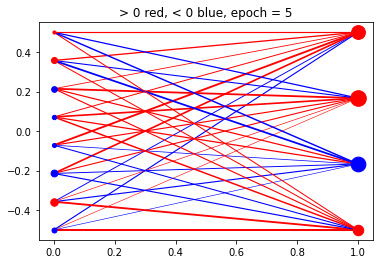

[[ 0.85012409 -0.31989336  0.37974467 -0.48764178]
 [ 0.64965039 -0.47655593  0.44069445 -0.64156123]
 [-0.53635254 -0.39906628  0.45180784  0.73378627]
 [-0.41125545 -0.35168756  0.3469963   0.93590337]
 [ 0.38821107  0.61573153  0.85228677  0.45447003]
 [ 0.29218241  0.38542306  0.83640393  0.29855513]
 [ 0.37053146 -0.69256461 -0.56025434  0.44279908]
 [ 0.55871231 -0.81314851 -0.51833184  0.4978377 ]] [ 0.02804214 -0.06222884 -0.0649062  -0.0575626   0.03665068 -0.03765296
 -0.02232041 -0.1171279 ] [ 0.25635853 -0.49262099  0.35622452  0.34674945] 10.0 4.0


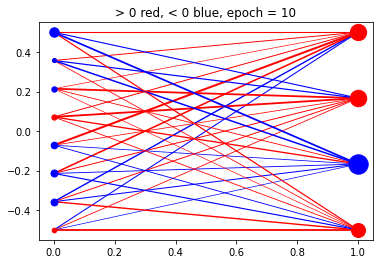

[[ 0.84967725 -0.3107388   0.30226491 -0.41152741]
 [ 0.80122088 -0.38523372  0.33320276 -0.49158679]
 [-0.57012193 -0.42433449  0.4579252   0.75226396]
 [-0.40038374 -0.3708293   0.37206832  0.95318225]
 [ 0.41982452  0.54000871  0.87066594  0.45000649]
 [ 0.3377674   0.43745144  0.85773807  0.28619124]
 [ 0.42088736 -0.70252818 -0.60893474  0.48936399]
 [ 0.48897647 -0.66676314 -0.58158631  0.53502073]] [-0.00225034 -0.0375133   0.01842972 -0.02645769  0.05418503  0.03240195
 -0.07335721 -0.10149628] [ 0.41999573 -0.49488202  0.30646809  0.37048037] 15.0 4.0


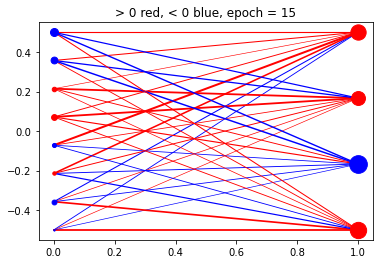

[[ 0.74641521 -0.40389546  0.40245462 -0.51404173]
 [ 0.79054029 -0.42312915  0.40783887 -0.49226713]
 [-0.46431667 -0.37915109  0.37484383  0.91458152]
 [-0.40226319 -0.35737504  0.36219187  0.85557224]
 [ 0.37797928  0.59325445  0.84779228  0.40601948]
 [ 0.39659258  0.49339756  0.81082711  0.36406616]
 [ 0.49115883 -0.77145098 -0.53849353  0.46712586]
 [ 0.5506422  -0.63060804 -0.55174692  0.54159387]] [-0.04485533 -0.10156395 -0.0129771   0.08638775  0.01660828 -0.0498966
  0.01655326 -0.00634736] [ 0.53108671 -0.38049716  0.49569314  0.46152539] 20.0 4.0


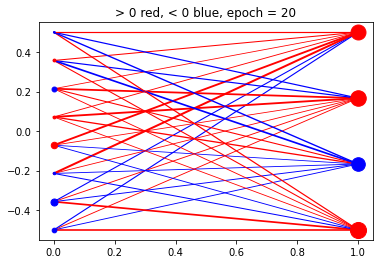

[[ 0.81115254 -0.32838275  0.39333407 -0.41058972]
 [ 0.81132565 -0.40816604  0.4162974  -0.48061389]
 [-0.4945433  -0.36773283  0.32754057  0.83322386]
 [-0.46992    -0.42229353  0.43318642  0.83941023]
 [ 0.3923467   0.60137964  0.74556007  0.44601137]
 [ 0.36128706  0.47840788  0.80187965  0.33203882]
 [ 0.44738855 -0.75286552 -0.58751125  0.47145089]
 [ 0.52785087 -0.83672471 -0.47115187  0.45735555]] [ 0.01380405 -0.00769811 -0.04695753 -0.05855213 -0.03761299 -0.0602101
  0.00757713 -0.06749807] [ 0.41870091 -0.47525319  0.46779619  0.44590914] 25.0 4.0


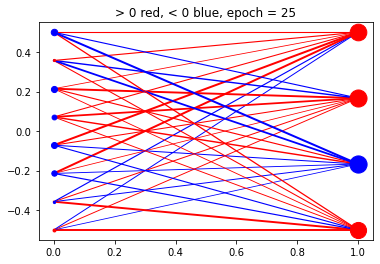

[[ 0.88968103 -0.32806504  0.29194628 -0.38941231]
 [ 0.8666242  -0.39047733  0.34647107 -0.48570332]
 [-0.57189935 -0.42283539  0.48401238  0.72354737]
 [-0.42677789 -0.33478329  0.37818184  0.88952112]
 [ 0.48942787  0.61317046  0.81249082  0.45887893]
 [ 0.52643498  0.60223974  0.75342388  0.38158216]
 [ 0.47025317 -0.75293032 -0.47895544  0.4152786 ]
 [ 0.37999226 -0.84919392 -0.39350038  0.50954398]] [-0.0269212  -0.05482643 -0.00473806 -0.09271146 -0.05487871 -0.09295515
  0.06991983 -0.04209857] [ 0.34645749 -0.4494008   0.50254054  0.3732124 ] 30.0 4.0


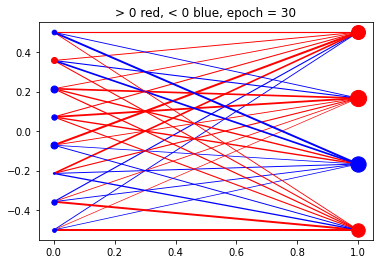

[[ 0.79621923 -0.38026201  0.44977834 -0.52919929]
 [ 0.74214419 -0.40618594  0.47911845 -0.52762513]
 [-0.62039491 -0.47257211  0.41954627  0.81264115]
 [-0.44265004 -0.38174079  0.36248003  0.82104985]
 [ 0.33581557  0.4742925   0.85828069  0.36487901]
 [ 0.36155113  0.430102    0.83024338  0.35422332]
 [ 0.46920575 -0.63749395 -0.52838546  0.50829862]
 [ 0.50486815 -0.75012244 -0.47271738  0.50519448]] [-0.06869815 -0.05047312 -0.02175851 -0.05037671 -0.0717729  -0.07541269
  0.01745268 -0.04819933] [ 0.45625803 -0.42031363  0.49533779  0.42147376] 35.0 4.0


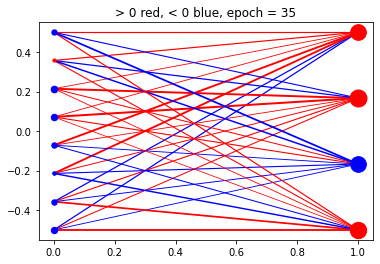

[[ 0.78512063 -0.39664524  0.38198744 -0.50609079]
 [ 0.77743769 -0.44274565  0.36877625 -0.54469032]
 [-0.52870144 -0.42138861  0.46241002  0.84376799]
 [-0.45921134 -0.3844912   0.40510819  0.83090156]
 [ 0.42128726  0.43784806  0.88088759  0.37789126]
 [ 0.46416837  0.49107898  0.80146575  0.41934472]
 [ 0.46929677 -0.61847254 -0.63767416  0.42660762]
 [ 0.43301732 -0.78616899 -0.48139115  0.45481788]] [-0.03051489 -0.1011376  -0.01423781 -0.0339907  -0.05051489 -0.02962721
  0.02293038 -0.05112978] [ 0.50756993 -0.49891495  0.52138858  0.39662589] 40.0 4.0


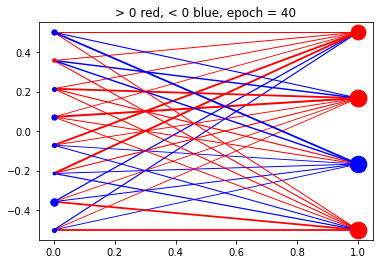

[[ 0.77262251 -0.40561102  0.40198977 -0.55150693]
 [ 0.74203055 -0.48518941  0.42356217 -0.57265755]
 [-0.49041835 -0.4250218   0.43004285  0.83973204]
 [-0.39051757 -0.36137782  0.34145455  0.86962859]
 [ 0.42354846  0.46305208  0.86295723  0.44832291]
 [ 0.44261907  0.5174595   0.79466049  0.38917835]
 [ 0.44014849 -0.69880424 -0.62680871  0.44498957]
 [ 0.39287067 -0.82347572 -0.44885826  0.37822416]] [-0.04837779 -0.05185599 -0.04109816 -0.00795265 -0.047337   -0.08140524
 -0.0214395  -0.05725564] [ 0.41426951 -0.48681985  0.50622746  0.36294236] 45.0 4.0


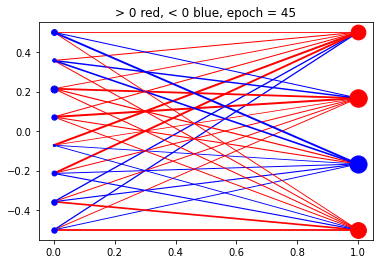

[[ 0.72947261 -0.44591459  0.37107003 -0.52797191]
 [ 0.81832837 -0.45827027  0.3989519  -0.59642926]
 [-0.52643517 -0.37381566  0.43872472  0.85346361]
 [-0.41957155 -0.33813038  0.31320429  0.85913667]
 [ 0.42888201  0.53192335  0.81003463  0.38331028]
 [ 0.45700787  0.55371066  0.74487376  0.46430702]
 [ 0.42472856 -0.71897028 -0.63043748  0.48742342]
 [ 0.37011919 -0.91436157 -0.39788526  0.35801665]] [-0.04392839 -0.09021473 -0.02736292 -0.07385324 -0.0941259  -0.04565471
  0.02686089 -0.05024438] [ 0.42460301 -0.45880219  0.51140039  0.36396601] 50.0 4.0


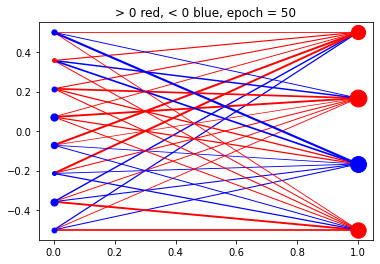

In [17]:
N, L, vmin, GAP, v_original, v0, v = load_data_01(q = 0.1, states = 5, PRINTING=True, SPINS=True)

M = 4

(x1, y1) = create_coord(L, 0) #visible units
(x2, y2) = create_coord(M, 1) #hidden units

v = v.astype(float)
vmin = float(vmin)
a, b, w, w_plot, a_plot, b_plot, epoch_plot, M_plot = RBM_train_jit(vmin, GAP, N, L, M, v, PRINTING=True)

for i in range(w_plot.shape[0]):
    print(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])
    plotgraph(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])

### Introducing a sixth state "5" <a name="3.2"></a>

each of N = 10000 data samples has L = 8 digits
[1 1 0 0 1 1 0 0]
[1 1 0 0 0 1 1 0]
[0 1 0 1 1 1 0 0]
[0 0 1 1 0 0 1 1]
[1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 1 1]
[0 0 1 1 1 0 1 1]
[0 0 1 1 1 1 0 0]
[1 1 0 0 1 1 0 0]
[0 0 0 1 1 0 1 1]
.....
[ 1  1 -1 -1  1  1 -1 -1]
[ 1  1 -1 -1 -1  1  1 -1]
[-1  1 -1  1  1  1 -1 -1]
[-1 -1  1  1 -1 -1  1  1]
[ 1  1 -1  1  1  1  1  1]
[ 1  1  1  1 -1  1  1  1]
[-1 -1  1  1  1 -1  1  1]
[-1 -1  1  1  1  1 -1 -1]
[ 1  1 -1 -1  1  1 -1 -1]
[-1 -1 -1  1  1 -1  1  1]
.....
------ epoch = 1   n = 499   m = 500
dw = [[-0.096 -0.072  0.18   0.156  0.112]
 [-0.008 -0.36  -0.076 -0.052  0.008]
 [-0.136  0.088  0.172  0.188  0.056]
 [-0.048  0.184 -0.14  -0.26  -0.096]
 [ 0.348 -0.012 -0.072 -0.064 -0.372]
 [ 0.276 -0.044  0.056  0.016 -0.124]
 [ 0.02  -0.084 -0.144  0.28   0.396]
 [-0.456  0.04   0.196 -0.108  0.224]]
da = [-0.088 -0.008 -0.048  0.312  0.468  0.188  0.052  0.048]
db = [ 0.032  0.096  0.22   0.116 -0.008]
------ epoch = 2   n = 499   m = 500
dw = [[-0.0

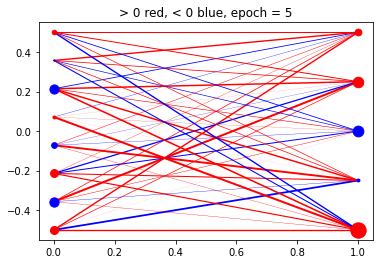

[[ 0.7331098  -0.79112227 -0.14537531  0.37085201  0.60434053]
 [ 0.29974684 -0.13768314  0.34343929  0.91379635  0.60265741]
 [ 0.60810274  0.53783216 -0.70454344 -0.5701902   0.03525229]
 [ 0.08856668  1.08335168 -0.1319092  -0.22098447  0.22992295]
 [ 1.03055225  0.01406524 -0.16708291  0.17481228 -0.39499311]
 [ 0.74925577  0.88369883  0.53939798  0.7165877  -0.28154867]
 [-0.61347163  0.4177924  -0.35669561  0.37175803  0.55474726]
 [-0.70598779  0.36346985 -0.42734292  0.47082516  0.63218463]] [ 0.2057312  -0.07817968  0.11890044 -0.11324221 -0.06462438 -0.1305739
  0.09027933  0.08403745] [ 0.4736689   0.11842305 -0.38816551  0.14202539 -0.07666804] 10.0 5.0


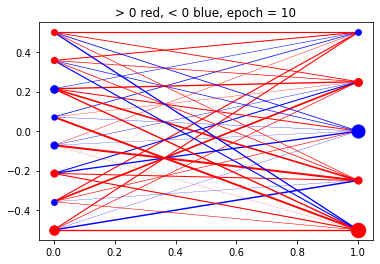

[[ 0.6633254  -0.78583994 -0.39007463  0.43151431  0.40463799]
 [ 0.20923079 -0.20702262  0.32040921  0.82698961  0.65354247]
 [ 0.5430078   0.72273035 -0.70958481 -0.51634174 -0.06903921]
 [ 0.07178147  1.03061906  0.06452436 -0.29500333  0.30822684]
 [ 0.98486758  0.12830067  0.00391384  0.24238616 -0.31194553]
 [ 0.65324254  0.85180937  0.690457    0.71182101 -0.19352766]
 [-0.71735171  0.39532061 -0.45726113  0.35002484  0.5566395 ]
 [-0.63376316  0.50826158 -0.42472766  0.38239321  0.61524747]] [ 0.16315088  0.04973266 -0.04475674 -0.07893886  0.00944986  0.06638774
  0.10618822  0.07649404] [ 0.67378132  0.04513075 -0.56237824 -0.0294814  -0.09724849] 15.0 5.0


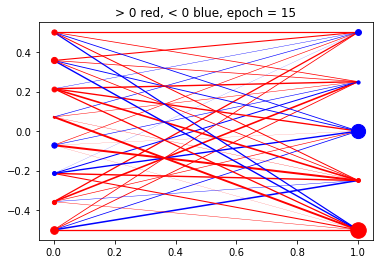

[[ 0.62717631 -0.72417765 -0.5607357   0.48475688  0.38703914]
 [ 0.22037854 -0.11863868  0.23707279  0.99721463  0.72303308]
 [ 0.54863784  0.61996579 -0.66108892 -0.53870276 -0.17588022]
 [ 0.07156949  1.07367147  0.05615486 -0.23591522  0.1637033 ]
 [ 1.08612877  0.05261347  0.02963096  0.2305284  -0.29826111]
 [ 0.73760932  0.63485582  0.81482354  0.45105636  0.01107713]
 [-0.75161929  0.50632685 -0.54070704  0.38819091  0.45289841]
 [-0.68548418  0.49785035 -0.52133045  0.30440416  0.47280737]] [ 0.06845604  0.05696742 -0.05856364 -0.00037716 -0.02097412  0.16674976
  0.0158387   0.09065301] [ 0.62685378 -0.07522541 -0.77739736 -0.08629457 -0.01017215] 20.0 5.0


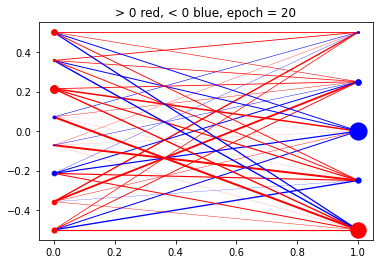

[[ 0.58316057 -0.73793807 -0.5871664   0.66537377  0.27738329]
 [ 0.21988094 -0.1763045   0.28015567  1.085633    0.54850001]
 [ 0.58841054  0.7098501  -0.56904297 -0.70305501  0.04542479]
 [ 0.13880343  1.03815531  0.06448426 -0.26128909  0.27737673]
 [ 1.09400924  0.16018803 -0.10017689  0.22293751 -0.47542981]
 [ 0.69436398  0.67415072  0.73790516  0.56507672 -0.18418487]
 [-0.47613448  0.46939328 -0.44867951  0.3171949   0.52406886]
 [-0.64356662  0.44849821 -0.45650775  0.34925444  0.61859775]] [ 0.01691865  0.04369017 -0.10990748 -0.10779843 -0.05498198  0.17338808
 -0.12536544  0.05431336] [ 0.73599575  0.08607194 -1.03411842 -0.05813008  0.11923127] 25.0 5.0


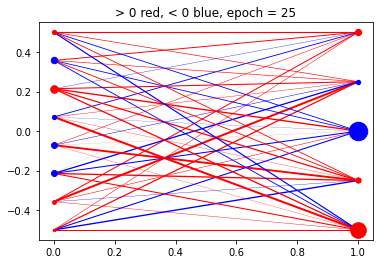

[[ 0.58108198 -0.77830799 -0.48100042  0.63659813  0.19962759]
 [ 0.2061428  -0.18832575  0.23356271  1.07250036  0.53424544]
 [ 0.51722273  0.56574449 -0.56975043 -0.6200337   0.09165019]
 [ 0.23155213  1.03297995 -0.0168525  -0.22800163  0.31035294]
 [ 1.02514425  0.12988891 -0.06388921  0.19252707 -0.47342559]
 [ 0.73942429  0.71650498  0.87048448  0.61123633 -0.08054288]
 [-0.5641378   0.44826901 -0.54539034  0.41899037  0.46713416]
 [-0.52320285  0.42873466 -0.59269312  0.37520021  0.56373895]] [ 0.13398538  0.00900555 -0.08352805 -0.08783006 -0.04205137  0.24090947
 -0.06847799 -0.07380196] [ 0.5966019   0.07352842 -0.86924163 -0.13761754  0.11348106] 30.0 5.0


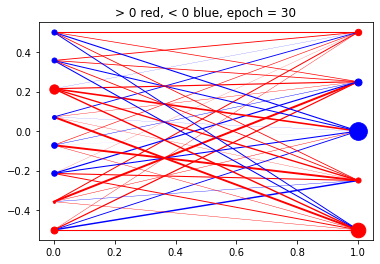

[[ 0.5479567  -0.75355383 -0.47393908  0.65631913  0.21958442]
 [ 0.21479971 -0.26262658  0.37656717  0.9806736   0.68877333]
 [ 0.68134649  0.63295494 -0.51646096 -0.61457378  0.11246646]
 [ 0.1383981   1.01736516  0.13048226 -0.18618736  0.34443653]
 [ 0.99178649  0.18196548 -0.03974778  0.29431401 -0.56515937]
 [ 0.70570833  0.63297477  0.92300039  0.56552092  0.0165515 ]
 [-0.51762854  0.49150602 -0.56929804  0.44835015  0.48341494]
 [-0.58042063  0.51300091 -0.53334268  0.44505878  0.50013152]] [ 0.06738302  0.05785675 -0.00591593 -0.08114402  0.0671849   0.26908825
 -0.09008318 -0.04225479] [ 0.67332943 -0.02766512 -0.79372906 -0.15499738  0.24845658] 35.0 5.0


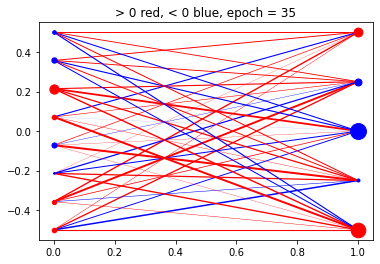

[[ 0.46952315 -0.71491807 -0.52297777  0.67191492  0.08929055]
 [ 0.18401183 -0.2163296   0.21939211  1.04009911  0.47940402]
 [ 0.62933731  0.60968984 -0.47215713 -0.72271598  0.22245281]
 [ 0.1378018   1.07603015  0.1317649  -0.18142754  0.32122099]
 [ 0.98016144  0.23601046 -0.13795785  0.27180462 -0.70382291]
 [ 0.70022476  0.57783346  0.91854867  0.67384189 -0.0413701 ]
 [-0.53330601  0.51211287 -0.57358467  0.50005604  0.45333707]
 [-0.51301812  0.45556132 -0.58954314  0.45260662  0.49134695]] [ 4.99741977e-02  6.44766507e-05 -3.58817130e-02 -4.28583298e-02
  1.16712579e-01  2.49578910e-01 -1.20505561e-01 -6.22301283e-02] [ 0.57775738  0.00349744 -0.87994326 -0.12988816  0.35271827] 40.0 5.0


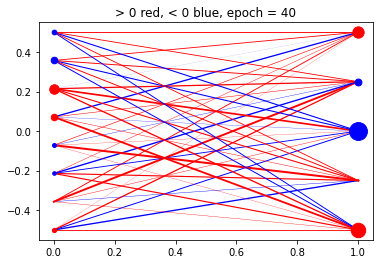

[[ 0.51915234 -0.61739337 -0.55423438  0.70194299  0.07058646]
 [ 0.20215091 -0.2029464   0.19381498  1.10171172  0.46360221]
 [ 0.61842093  0.54083794 -0.45824779 -0.77431327  0.24770495]
 [ 0.08562551  1.13829279  0.07986965 -0.13383279  0.2808257 ]
 [ 1.01109999  0.21504078 -0.10255154  0.19942613 -0.63895465]
 [ 0.65089606  0.61382072  0.89672912  0.60746178 -0.06785758]
 [-0.51546882  0.42319784 -0.5403874   0.45907498  0.42447743]
 [-0.52622842  0.44152389 -0.65499497  0.50600994  0.47046272]] [ 0.01892664 -0.00030894 -0.04139773  0.01243892  0.1075238   0.2744182
 -0.18239642 -0.19801483] [ 0.69566273 -0.14283417 -0.97216026 -0.20143245  0.5813793 ] 45.0 5.0


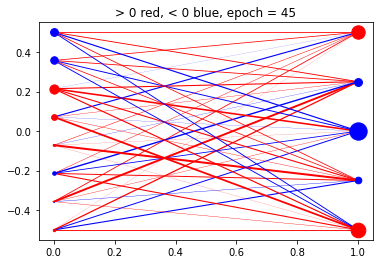

[[ 0.52819765 -0.68456656 -0.54376466  0.70822689  0.04329931]
 [ 0.20254827 -0.24324913  0.2533556   1.06148077  0.42407472]
 [ 0.57858029  0.61389432 -0.49444877 -0.67905706  0.12613119]
 [ 0.12592342  0.97459162  0.14579188 -0.22184503  0.32217833]
 [ 1.02058836  0.19668979 -0.0717099   0.21385824 -0.69196146]
 [ 0.73419766  0.59590569  0.93547544  0.56859573 -0.05567472]
 [-0.55733059  0.56951955 -0.54884378  0.50850058  0.35291794]
 [-0.62542907  0.50927136 -0.6027827   0.50931616  0.47206834]] [-0.00626982  0.00977308 -0.04742676  0.00196001  0.12082883  0.27102444
 -0.1505224  -0.12332325] [ 0.62361189 -0.0544209  -1.00072426 -0.18614615  0.53970751] 50.0 5.0


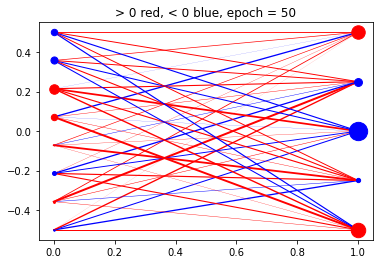

In [18]:
N, L, vmin, GAP, v_original, v0, v = load_data_01(q = 0.1, states = 6, PRINTING=True, SPINS=True)

M = 5

(x1, y1) = create_coord(L, 0) #visible units
(x2, y2) = create_coord(M, 1) #hidden units

v = v.astype(float)
vmin = float(vmin)
a, b, w, w_plot, a_plot, b_plot, epoch_plot, M_plot = RBM_train_jit(vmin, GAP, N, L, M, v, PRINTING=True)

for i in range(w_plot.shape[0]):
    print(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])
    plotgraph(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])

## Plotting score for a range of values of $M$ and $beta$, SPIN = True, $q = 0.1$

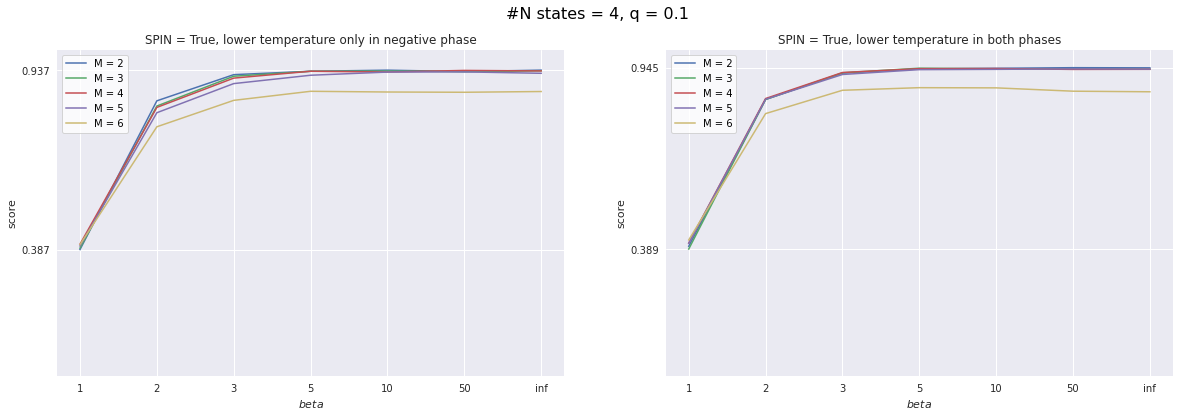

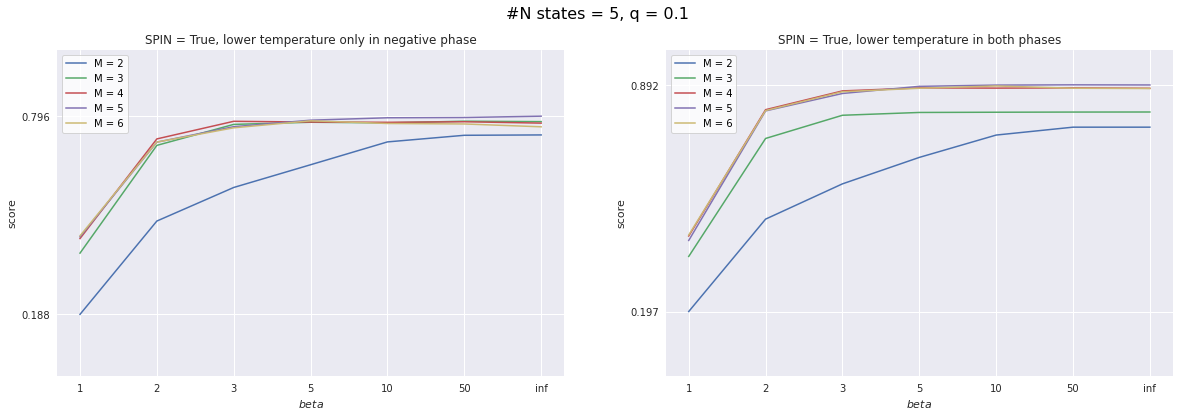

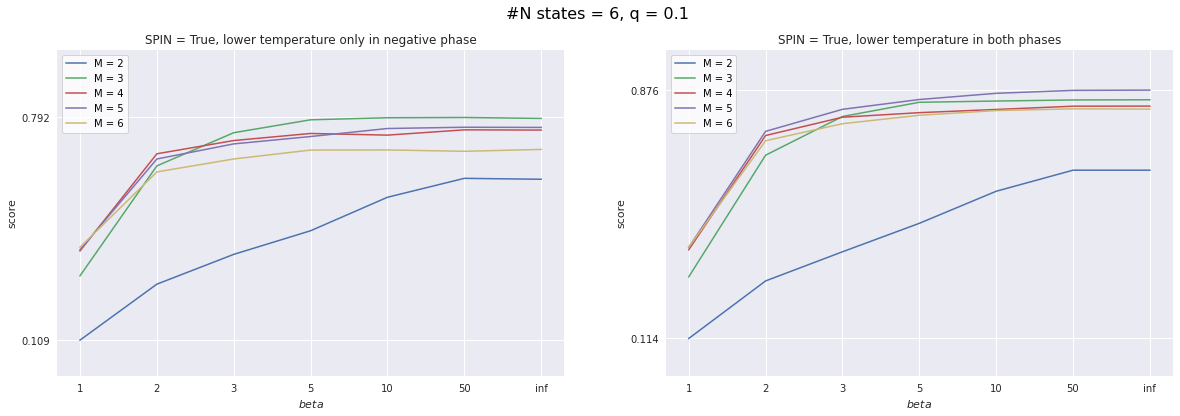

In [19]:
for state in (4, 5, 6):
    plot_scores_M(q=0.1, states=state)

# 4. Repeat the analysis with a larger error rate q=0.2 <a name="4"></a>

Repeat the above points for systems with larger error rate q=0.2.

### 4 states

each of N = 10000 data samples has L = 8 digits
[1 1 0 0 1 1 0 0]
[0 1 0 0 0 1 1 0]
[0 1 1 1 1 0 0 0]
[0 0 1 1 0 0 1 1]
[0 1 0 0 0 0 1 1]
[0 1 1 0 0 0 1 0]
[1 1 0 0 0 1 1 1]
[0 1 0 0 0 0 1 1]
[0 0 0 1 1 1 1 0]
[1 1 0 0 1 0 1 0]
.....
[ 1  1 -1 -1  1  1 -1 -1]
[-1  1 -1 -1 -1  1  1 -1]
[-1  1  1  1  1 -1 -1 -1]
[-1 -1  1  1 -1 -1  1  1]
[-1  1 -1 -1 -1 -1  1  1]
[-1  1  1 -1 -1 -1  1 -1]
[ 1  1 -1 -1 -1  1  1  1]
[-1  1 -1 -1 -1 -1  1  1]
[-1 -1 -1  1  1  1  1 -1]
[ 1  1 -1 -1  1 -1  1 -1]
.....
------ epoch = 1   n = 499   m = 500
dw = [[-0.236 -0.208 -0.288]
 [ 0.028 -0.032 -0.2  ]
 [-0.136 -0.028  0.06 ]
 [-0.124  0.024  0.056]
 [ 0.124  0.288  0.36 ]
 [-0.464 -0.46  -0.276]
 [-0.152 -0.1   -0.26 ]
 [ 0.184  0.1   -0.028]]
da = [ 0.08  -0.232 -0.284 -0.216 -0.224  0.268  0.444 -0.276]
db = [0.028 0.144 0.088]
------ epoch = 2   n = 499   m = 500
dw = [[ 0.08        0.07619048 -0.03047619]
 [-0.04952381  0.02285714 -0.09142857]
 [-0.00761905 -0.12571429 -0.10285714]
 [ 0.0152381   0.1

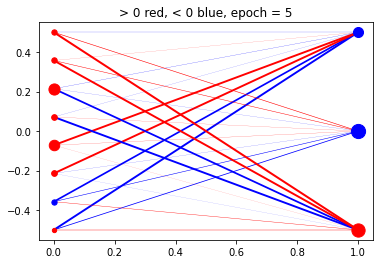

[[ 0.02186427 -0.17067287 -0.69218825]
 [ 0.19862595 -0.26069071 -0.64045277]
 [ 0.02574673  0.12229291  0.74958102]
 [-0.1068627   0.10676696  0.67137133]
 [-0.86131415 -0.04412963 -0.03022996]
 [-0.61496057 -0.24629889  0.00584438]
 [ 0.55339992  0.54053446 -0.197134  ]
 [ 0.56024641  0.2180749  -0.15604636]] [-0.01150408 -0.05188684  0.00954613  0.03571194  0.02583819  0.03297118
 -0.04838894  0.06477163] [ 0.12640377  0.12658037 -0.02977895] 10.0 3.0


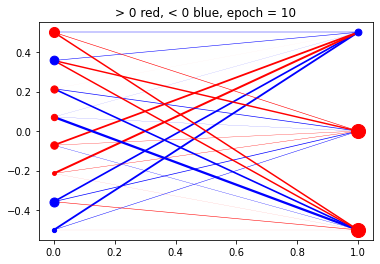

[[ 0.0625291  -0.13981918 -0.74156925]
 [ 0.06447535 -0.1125774  -0.6457167 ]
 [-0.02493051 -0.02807426  0.65431847]
 [-0.17396663  0.24445968  0.57915378]
 [-0.79931061 -0.20393815 -0.03001856]
 [-0.41736518 -0.3700667   0.05559657]
 [ 0.4937257   0.39709435 -0.01069967]
 [ 0.44948645  0.40109353 -0.1300499 ]] [ 0.00142364 -0.00788425  0.03619337  0.04714489 -0.08688227 -0.00686071
 -0.02444526  0.02159248] [ 0.04784653  0.0333938  -0.06261461] 15.0 3.0


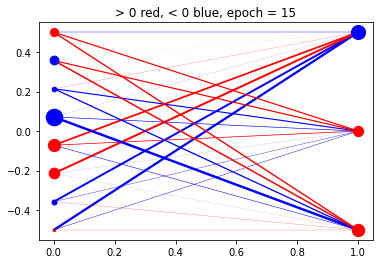

[[ 0.02016712 -0.10472306 -0.5147391 ]
 [ 0.0824938  -0.27741314 -0.53590025]
 [ 0.03864209  0.23290544  0.68229373]
 [-0.11290087  0.40023805  0.53794884]
 [-0.63346045 -0.18846019  0.10007556]
 [-0.65638661 -0.18813552  0.05848138]
 [ 0.63363676  0.2577101  -0.12812166]
 [ 0.70915551  0.17357142 -0.08526393]] [-0.02148378  0.01806522 -0.01611948  0.04138782  0.00153258 -0.021161
 -0.0180269  -0.02471903] [ 0.10592615 -0.0053381   0.01177577] 20.0 3.0


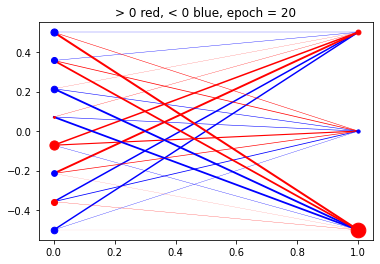

[[ 0.09884181 -0.18513426 -0.57445038]
 [ 0.04499896 -0.36238461 -0.64245587]
 [ 0.00852632  0.24855014  0.50583252]
 [-0.02040295  0.29108591  0.49875626]
 [-0.66724347 -0.12933475  0.10626022]
 [-0.66000348 -0.25017632  0.0815666 ]
 [ 0.58696887  0.31205739 -0.24077728]
 [ 0.7521743   0.09724465 -0.14269876]] [ 0.02555055  0.07240469 -0.00519685 -0.06457938  0.02599288  0.03791226
 -0.09098396 -0.03515459] [ 0.03098418  0.32207717 -0.07818888] 25.0 3.0


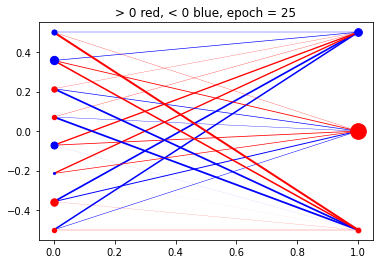

[[-0.00647626 -0.28628859 -0.59032035]
 [ 0.00743138 -0.3082737  -0.57399636]
 [-0.01914568  0.32079481  0.59530781]
 [-0.05114149  0.45001889  0.51525479]
 [-0.67497966 -0.0732076   0.10444026]
 [-0.70585055 -0.09525757 -0.03193817]
 [ 0.63681569  0.35229612 -0.19730889]
 [ 0.62587941  0.02092943 -0.04163144]] [ 0.0891235   0.0313144   0.01544858 -0.06439762 -0.0332597  -0.05800648
 -0.02835108  0.06717137] [-0.11449086  0.23214867 -0.11827296] 30.0 3.0


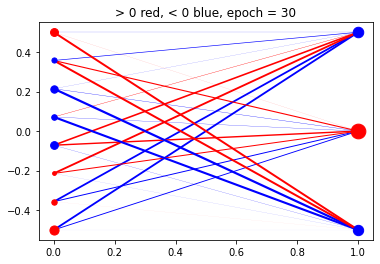

[[-0.04721944 -0.34170362 -0.57124338]
 [ 0.01214    -0.3647241  -0.5461208 ]
 [-0.03991698  0.48644257  0.35637972]
 [-0.05735881  0.40478352  0.40612085]
 [-0.72541165 -0.06222894  0.10798821]
 [-0.67319881 -0.12988657  0.08799911]
 [ 0.58244415  0.34544971 -0.36295796]
 [ 0.66002702  0.08030137 -0.079486  ]] [ 0.06219587  0.07827122 -0.10225388 -0.11646787  0.01841553 -0.03781023
 -0.00360736  0.01258576] [-0.05028152  0.27378367  0.03273619] 35.0 3.0


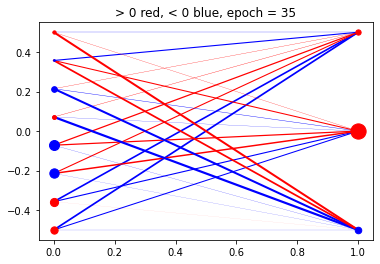

[[ 0.0245972  -0.37648932 -0.46957979]
 [-0.03803709 -0.34912383 -0.54491044]
 [-0.09582197  0.43967711  0.4075738 ]
 [-0.09937638  0.53732762  0.389297  ]
 [-0.66489537 -0.09238958  0.04452801]
 [-0.68318545 -0.1403038   0.14573937]
 [ 0.68453516  0.31056872 -0.15448394]
 [ 0.6725395   0.16355779 -0.17644833]] [-0.02048362  0.03683956  0.00137426 -0.05556328  0.01237584  0.01566202
 -0.00683736 -0.0276367 ] [0.05352403 0.04539989 0.02704563] 40.0 3.0


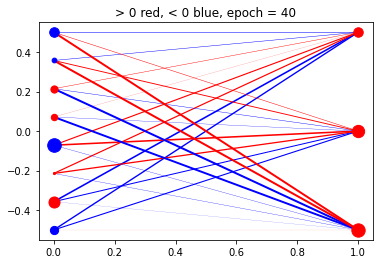

[[ 0.11803871 -0.32321959 -0.51663234]
 [ 0.04106402 -0.31832979 -0.60816962]
 [-0.14272307  0.49298612  0.43063579]
 [-0.03173989  0.3434839   0.43693346]
 [-0.68188563 -0.12211503  0.05978697]
 [-0.69581784 -0.1724397   0.05856662]
 [ 0.59438724  0.20302463 -0.12538662]
 [ 0.62136681  0.2119679  -0.1373764 ]] [ 0.03129203 -0.00105049 -0.00568285  0.0035485   0.00029769  0.00464843
  0.01278413 -0.00056409] [-0.05319034  0.09804045 -0.08654367] 45.0 3.0


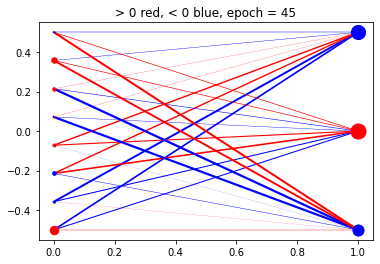

[[ 0.03398378 -0.46530194 -0.3264033 ]
 [-0.05181931 -0.33350247 -0.60211839]
 [-0.06797277  0.54548562  0.29987482]
 [-0.01985013  0.45061795  0.34248565]
 [-0.69473482 -0.08278804  0.09503949]
 [-0.67994838 -0.13548274  0.15031798]
 [ 0.69950802 -0.04694153  0.07310421]
 [ 0.64373188  0.03159495  0.01209438]] [ 0.03502037  0.01034105  0.01652139  0.01195482 -0.02211709 -0.02384424
  0.02690338 -0.01436465] [-0.00207904 -0.03336022  0.02187203] 50.0 3.0


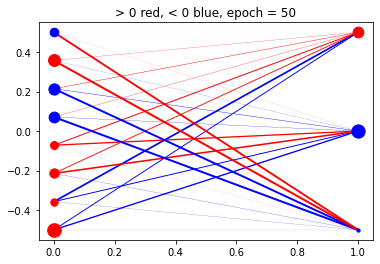

In [20]:
N, L, vmin, GAP, v_original, v0, v = load_data_01(q = 0.2, states = 4, PRINTING=True, SPINS=True)

M = 3

(x1, y1) = create_coord(L, 0) #visible units
(x2, y2) = create_coord(M, 1) #hidden units

v = v.astype(float)
vmin = float(vmin)
a, b, w, w_plot, a_plot, b_plot, epoch_plot, M_plot = RBM_train_jit(vmin, GAP, N, L, M, v, PRINTING=True)

for i in range(w_plot.shape[0]):
    print(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])
    plotgraph(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])

### 5 states

each of N = 10000 data samples has L = 8 digits
[1 1 0 0 1 1 0 0]
[0 1 0 0 0 1 1 0]
[0 1 1 1 1 0 0 0]
[0 0 1 1 0 0 1 1]
[1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 0 1]
[0 1 1 1 1 0 1 1]
[0 0 1 1 1 1 0 0]
[1 1 0 0 1 1 1 0]
[0 0 0 1 1 0 1 1]
.....
[ 1  1 -1 -1  1  1 -1 -1]
[-1  1 -1 -1 -1  1  1 -1]
[-1  1  1  1  1 -1 -1 -1]
[-1 -1  1  1 -1 -1  1  1]
[ 1  1 -1  1  1  1  1  1]
[ 1  1  1  1 -1  1 -1  1]
[-1  1  1  1  1 -1  1  1]
[-1 -1  1  1  1  1 -1 -1]
[ 1  1 -1 -1  1  1  1 -1]
[-1 -1 -1  1  1 -1  1  1]
.....
------ epoch = 1   n = 499   m = 500
dw = [[ 0.1    0.168  0.16   0.04 ]
 [ 0.228 -0.28  -0.312 -0.248]
 [-0.328 -0.18  -0.148 -0.028]
 [ 0.104  0.188  0.26   0.316]
 [-0.076 -0.12  -0.168 -0.096]
 [-0.028  0.048  0.064  0.112]
 [-0.044 -0.408 -0.24   0.056]
 [ 0.044  0.104  0.144  0.176]]
da = [-0.224  0.48   0.068  0.212  0.072  0.544 -0.152 -0.072]
db = [0.028 0.112 0.128 0.08 ]
------ epoch = 2   n = 499   m = 500
dw = [[-0.03047619 -0.03047619  0.02666667  0.02285714]
 [-0.01904762 -0.05714

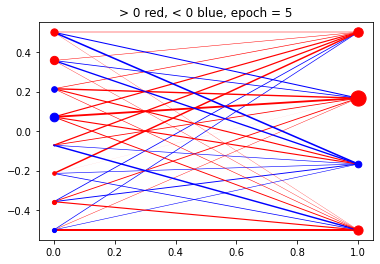

[[ 0.57601478 -0.45706933  0.3449537  -0.58960758]
 [ 0.57162473 -0.19124501  0.09713052 -0.28369915]
 [-0.38343056 -0.2486492   0.36992837  0.35867059]
 [-0.42239444 -0.27745684  0.37938214  0.45662447]
 [ 0.27701847  0.42357187  0.5659058   0.28984259]
 [ 0.30460671  0.29895855  0.50679311  0.17905563]
 [ 0.1560361  -0.48200771 -0.35194938  0.30906028]
 [ 0.21595105 -0.5923916  -0.21142888  0.24319762]] [-0.0716482  -0.06410483 -0.05081916 -0.07829683 -0.02790407 -0.02623126
 -0.08180656 -0.03709957] [ 0.45955121 -0.44167857  0.57008281  0.28492439] 10.0 4.0


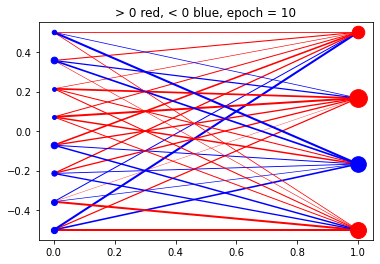

[[ 0.5856282  -0.42654596  0.14323956 -0.32897237]
 [ 0.45718729 -0.29143572  0.07942389 -0.22302263]
 [-0.48641043 -0.1339976   0.43485825  0.6109658 ]
 [-0.28971851 -0.15671939  0.26383579  0.55714388]
 [ 0.17479827  0.21150956  0.63424368  0.03957414]
 [ 0.18919557  0.47138239  0.61721854  0.14996552]
 [ 0.2120769  -0.49301987 -0.2390319   0.29734983]
 [ 0.19991943 -0.47804136 -0.27169853  0.3598697 ]] [-1.02856838e-01 -1.16275036e-04 -7.26476632e-02 -9.19782454e-02
  7.03423609e-03  7.68624332e-02 -1.57883957e-01 -6.60874659e-02] [ 0.48410509 -0.54352777  0.34753494  0.60430916] 15.0 4.0


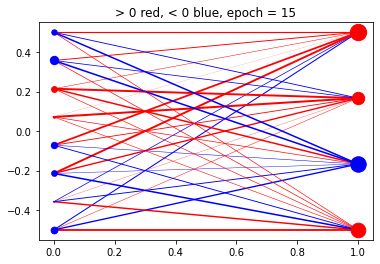

[[ 0.45844823 -0.36394134  0.38011171 -0.49601156]
 [ 0.48716587 -0.19446812  0.26526968 -0.31358096]
 [-0.44641385 -0.35064629  0.14572566  0.70988529]
 [-0.26489109 -0.30021786  0.28388869  0.50257844]
 [ 0.15148771  0.19417691  0.6888279   0.15490337]
 [ 0.10652703  0.23674438  0.61672087  0.21380035]
 [ 0.33262201 -0.4478144  -0.433339    0.25629769]
 [ 0.25695688 -0.49258762 -0.32662856  0.29856833]] [-0.02828865 -0.00985584  0.03267023 -0.0138268   0.01033898 -0.05204664
 -0.09811683 -0.05433737] [ 0.65226862 -0.22030059  0.32914765  0.52906061] 20.0 4.0


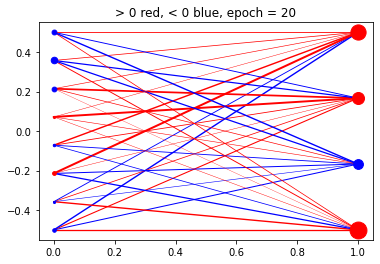

[[ 0.47995251 -0.29156049  0.35851155 -0.29972792]
 [ 0.51060321 -0.3349125   0.35439983 -0.28987526]
 [-0.39382147 -0.22880576  0.0948216   0.6646515 ]
 [-0.32969563 -0.2379798   0.16558566  0.54062838]
 [ 0.13983696  0.34830025  0.55629767  0.37098757]
 [ 0.1146283   0.33162713  0.55383379  0.21313636]
 [ 0.38978679 -0.56636077 -0.34628253  0.33691448]
 [ 0.23213934 -0.63118987 -0.13230083  0.12847941]] [-0.05253857  0.04269077  0.00938238 -0.04364633 -0.16650551 -0.07369228
 -0.04653601 -0.02804578] [ 0.71675788 -0.33329182  0.35977598  0.68372431] 25.0 4.0


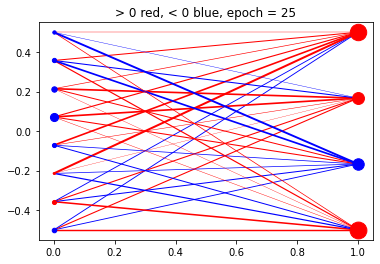

[[ 0.55851065 -0.22134108  0.25285942 -0.39196298]
 [ 0.52238273 -0.20573362  0.23164612 -0.38184716]
 [-0.34441862 -0.33690225  0.28245273  0.50795995]
 [-0.37550549 -0.31690028  0.28830454  0.52099033]
 [ 0.32390086  0.50992649  0.59679444  0.31644159]
 [ 0.17713441  0.27161831  0.49858228  0.11242006]
 [ 0.27280955 -0.65997295 -0.2567002   0.133787  ]
 [ 0.22720611 -0.57341581 -0.26642737  0.27651947]] [-0.08492588 -0.04906591 -0.04653196 -0.0908832  -0.13339828 -0.07782397
 -0.0428032  -0.10982954] [ 0.53429803 -0.51858617  0.54805708  0.47456659] 30.0 4.0


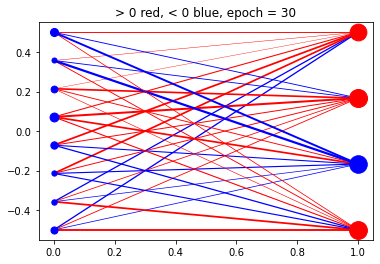

[[ 0.57770401 -0.16886445  0.20642497 -0.39831803]
 [ 0.55421599 -0.15266565  0.27434725 -0.38245913]
 [-0.35944647 -0.30490133  0.14738742  0.59065216]
 [-0.24969733 -0.29858962  0.1827254   0.53076998]
 [ 0.15551428  0.29862603  0.57158522  0.24265183]
 [ 0.1847815   0.36873242  0.59377747  0.27513906]
 [ 0.32148488 -0.53455108 -0.35614726  0.22831964]
 [ 0.34826824 -0.5672231  -0.21037628  0.10484742]] [-0.2011667  -0.13033132 -0.00424577 -0.07106897 -0.08458356 -0.1386104
 -0.13364157 -0.14621842] [ 0.78971116 -0.46217665  0.42687854  0.45011361] 35.0 4.0


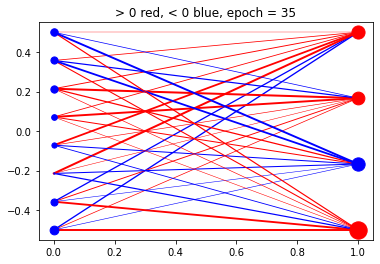

[[ 0.60676983 -0.21810185  0.26165259 -0.37601917]
 [ 0.47429229 -0.23774547  0.25839758 -0.41869225]
 [-0.37776702 -0.31106111  0.2171681   0.68000831]
 [-0.37052941 -0.30026246  0.27416848  0.53299616]
 [ 0.17634509  0.26635881  0.56708698  0.17898071]
 [ 0.29778788  0.39016     0.52183033  0.25757431]
 [ 0.30140448 -0.46492527 -0.40400561  0.16896923]
 [ 0.28265792 -0.60832331 -0.36427235  0.17613598]] [-0.12319746 -0.14173784 -0.00302569 -0.04760264 -0.06690883 -0.0556425
 -0.03845675 -0.10804141] [ 0.7635388  -0.57201003  0.4979414   0.4021982 ] 40.0 4.0


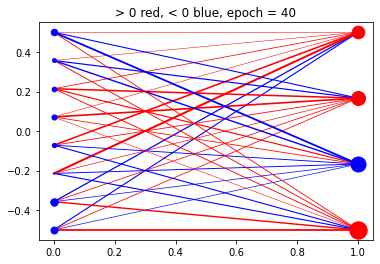

[[ 0.52690408 -0.23492312  0.20526178 -0.27726975]
 [ 0.52580876 -0.29129159  0.22818533 -0.36861084]
 [-0.42582088 -0.27230498  0.28950561  0.58980551]
 [-0.38334372 -0.23288877  0.17302282  0.51373708]
 [ 0.21381212  0.22993317  0.71300755  0.27005041]
 [ 0.31490007  0.41733662  0.517794    0.20221225]
 [ 0.26350345 -0.4798344  -0.46208737  0.23703969]
 [ 0.0906854  -0.71013873 -0.21135986  0.12863146]] [-0.12527543 -0.07911614 -0.04186091 -0.02516844 -0.14133476 -0.08360331
 -0.0722725  -0.10910303] [ 0.66121549 -0.50542982  0.45973402  0.49312994] 45.0 4.0


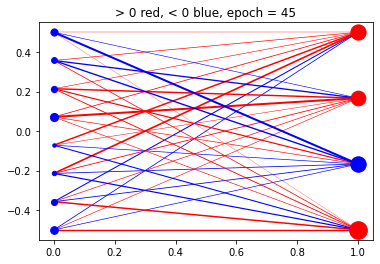

[[ 0.39714887 -0.32880297  0.32392117 -0.41287161]
 [ 0.5366591  -0.31124439  0.20498708 -0.47859871]
 [-0.41850943 -0.18868856  0.32759422  0.66575216]
 [-0.34636723 -0.18374275  0.23789085  0.5313511 ]
 [ 0.17437126  0.28503333  0.60515292  0.09923189]
 [ 0.25434102  0.38410273  0.55486957  0.21466554]
 [ 0.3107522  -0.5406733  -0.38790591  0.28744285]
 [ 0.23288361 -0.59830789 -0.2729327   0.17880096]] [-0.13982876 -0.14321925  0.02979063 -0.02416992 -0.08243623 -0.10599658
 -0.07756665 -0.049365  ] [ 0.75973384 -0.47774837  0.44631277  0.46062521] 50.0 4.0


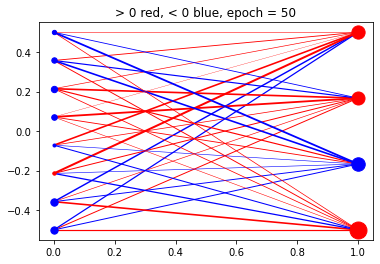

In [21]:
N, L, vmin, GAP, v_original, v0, v = load_data_01(q = 0.2, states = 5, PRINTING=True, SPINS=True)

M = 4

(x1, y1) = create_coord(L, 0) #visible units
(x2, y2) = create_coord(M, 1) #hidden units

v = v.astype(float)
vmin = float(vmin)
a, b, w, w_plot, a_plot, b_plot, epoch_plot, M_plot = RBM_train_jit(vmin, GAP, N, L, M, v, PRINTING=True)

for i in range(w_plot.shape[0]):
    print(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])
    plotgraph(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])

### 6 states

each of N = 10000 data samples has L = 8 digits
[1 1 0 0 1 1 0 0]
[0 1 0 0 0 1 1 0]
[0 1 1 1 1 0 0 0]
[0 0 1 1 0 0 1 1]
[1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 0 1]
[0 1 1 1 1 0 1 1]
[0 0 1 1 1 1 0 0]
[1 1 0 0 1 1 1 0]
[0 0 0 1 1 0 1 1]
.....
[ 1  1 -1 -1  1  1 -1 -1]
[-1  1 -1 -1 -1  1  1 -1]
[-1  1  1  1  1 -1 -1 -1]
[-1 -1  1  1 -1 -1  1  1]
[ 1  1 -1  1  1  1  1  1]
[ 1  1  1  1 -1  1 -1  1]
[-1  1  1  1  1 -1  1  1]
[-1 -1  1  1  1  1 -1 -1]
[ 1  1 -1 -1  1  1  1 -1]
[-1 -1 -1  1  1 -1  1  1]
.....
------ epoch = 1   n = 499   m = 500
dw = [[-0.072  0.096  0.164  0.108  0.088]
 [ 0.056 -0.256 -0.116  0.028 -0.08 ]
 [-0.136  0.088  0.148  0.156  0.   ]
 [ 0.032  0.048 -0.06  -0.268 -0.12 ]
 [ 0.16  -0.064 -0.052 -0.076 -0.216]
 [ 0.184 -0.128  0.02  -0.012 -0.152]
 [ 0.028 -0.02  -0.096  0.184  0.276]
 [-0.348 -0.012  0.096 -0.104  0.092]]
da = [-0.152  0.    -0.048  0.288  0.432  0.16  -0.004  0.044]
db = [0.048 0.064 0.212 0.1   0.016]
------ epoch = 2   n = 499   m = 500
dw = [[-0.015238

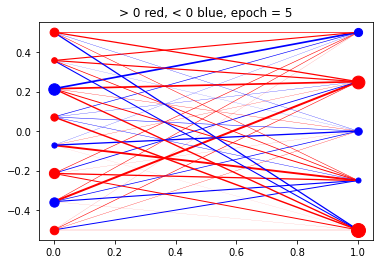

[[ 0.16525834 -0.37656099  0.03418444  0.50968028  0.18129457]
 [ 0.06350744 -0.03039336 -0.08724718  0.64619924 -0.07242144]
 [ 0.31876315  0.36387184 -0.03128878 -0.61536245  0.75986731]
 [ 0.27347008  0.47529983 -0.69149142 -0.31401791 -0.20242387]
 [ 0.49632195  0.06633972  0.2178193   0.03711318  0.10182614]
 [ 0.47544723  0.68326234  0.10076238  0.56808776 -0.16360559]
 [-0.43752369  0.09998927 -0.43541595  0.28766775  0.27758935]
 [-0.644832    0.24381716 -0.28549557  0.38526649  0.25130907]] [ 0.14031033 -0.07111335  0.10522461  0.0270753   0.00515892 -0.19102194
  0.04556521  0.11295812] [ 0.43240498 -0.06490574  0.08588188  0.14691911  0.26807627] 10.0 5.0


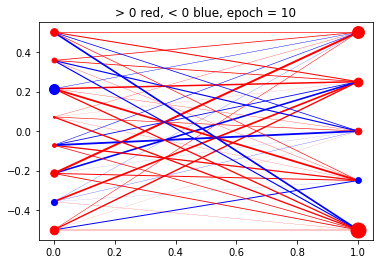

[[ 0.2907264  -0.48305495 -0.2532808   0.34754838  0.27158237]
 [ 0.13596107 -0.0968224  -0.45321745  0.5112672   0.05389395]
 [ 0.33248735  0.65544559  0.12940131 -0.45666706  0.72694853]
 [ 0.03667122  0.62238473 -0.50099289 -0.44114924 -0.20744791]
 [ 0.62667854  0.01350877  0.0729586   0.06994312 -0.03358209]
 [ 0.50532463  0.44228726  0.03655526  0.28072683 -0.26784762]
 [-0.48355396  0.13585236 -0.42624762  0.23755249  0.23918509]
 [-0.42637036  0.24055461 -0.25489667  0.32465821  0.2321443 ]] [ 0.05467138 -0.08898834  0.10291436  0.14371942  0.07368198 -0.0451458
  0.06438744  0.0890954 ] [ 0.40711351 -0.30076609  0.00891776  0.12943351  0.43523595] 15.0 5.0


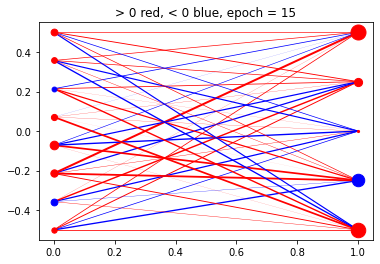

[[ 0.2960394  -0.56075253 -0.3260168   0.28318709  0.1491247 ]
 [ 0.25594978 -0.10657577 -0.26201471  0.79424003  0.00370975]
 [ 0.3628002   0.38597879  0.07499268 -0.44614303  0.50477537]
 [-0.12335466  0.61370472 -0.52380213 -0.34657053 -0.18153675]
 [ 0.6970275  -0.06852768 -0.09254653 -0.08949441 -0.12905257]
 [ 0.43506087  0.2678445  -0.09713549  0.26376506 -0.39226863]
 [-0.57564228  0.23057393 -0.27934584  0.33870918  0.32626294]
 [-0.42136816  0.2829782  -0.21197618  0.28490661  0.48386168]] [ 0.10513174  0.04667089  0.01829768  0.23285986  0.03357699 -0.00312835
  0.11653396  0.19757594] [ 0.4998765  -0.25435128  0.23100319 -0.04314501  0.37400786] 20.0 5.0


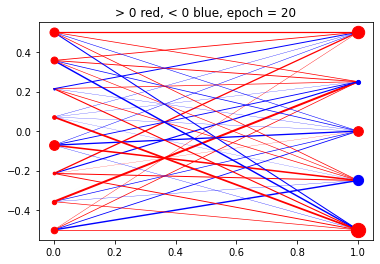

[[ 0.31618407 -0.40785639 -0.32426595  0.34639177  0.54580736]
 [ 0.10101696  0.07855435 -0.34858062  0.77864482  0.12130483]
 [ 0.27833418  0.34644281 -0.06688687 -0.55455204  0.27601284]
 [-0.0579419   0.52788369 -0.51910948 -0.50671577 -0.28389101]
 [ 0.63732901 -0.16920209 -0.16243903 -0.10696936 -0.05313853]
 [ 0.62191858  0.31702149 -0.07812293  0.25978601 -0.21843224]
 [-0.47290063  0.39193399 -0.14474872  0.16553891  0.24142079]
 [-0.52094957  0.45104175 -0.17545509  0.11965601  0.47408213]] [ 0.05971414  0.10372566  0.1055214   0.22757083  0.13487943 -0.12290796
  0.09444191  0.11272902] [ 0.57457029 -0.04950157  0.37370871 -0.01919404  0.64247515] 25.0 5.0


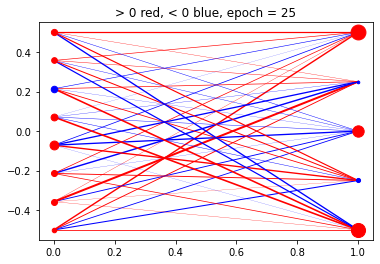

[[ 0.35017196 -0.42962246 -0.18999079  0.45803145  0.49236175]
 [-0.00346811  0.04786637 -0.08489964  0.59885617  0.08358337]
 [ 0.44088417  0.52885812 -0.02063028 -0.61646977  0.39582307]
 [ 0.0671953   0.54450164 -0.29779518 -0.19394966 -0.12131496]
 [ 0.60665815 -0.11439048 -0.28677887 -0.02267592 -0.13255395]
 [ 0.64332508  0.33041669 -0.00743607  0.43218883 -0.37824992]
 [-0.43935505  0.42692585 -0.10545083  0.27270514  0.40118592]
 [-0.39731494  0.43599924  0.06210296  0.25670032  0.42290528]] [ 0.12479979  0.13563746  0.08089778  0.26577205  0.21279354 -0.08858862
  0.14100858  0.03947877] [ 0.54158914 -0.13708619  0.88027856 -0.06236664  0.53037134] 30.0 5.0


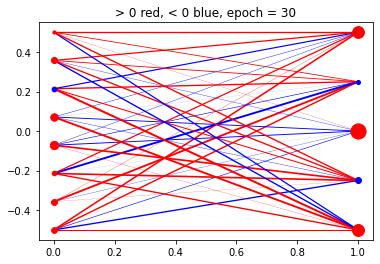

[[ 0.30751755 -0.41248642 -0.26331777  0.35433813  0.48064217]
 [ 0.12900102  0.06038797 -0.20229668  0.69686141  0.2913236 ]
 [ 0.36870103  0.48078952 -0.0361408  -0.56096595  0.28180894]
 [-0.06797092  0.58193143 -0.25825644 -0.19165713 -0.13962316]
 [ 0.62880524 -0.06206201 -0.31706512 -0.07752387 -0.13397051]
 [ 0.62821627  0.38418587 -0.03340875  0.381684   -0.3698512 ]
 [-0.48846776  0.50091034 -0.14987331  0.26118924  0.39887828]
 [-0.52851798  0.41151674 -0.06156728  0.23300262  0.37584077]] [ 0.15375032  0.09152904  0.05969811  0.22288284  0.29077538 -0.01516463
  0.15460489  0.13930572] [ 0.63433983 -0.06992757  0.97267165 -0.14161373  0.57007898] 35.0 5.0


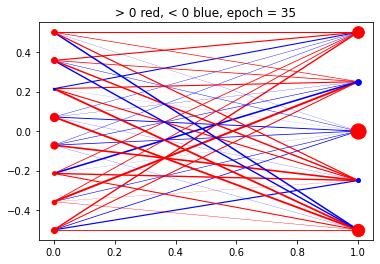

[[ 0.25666753 -0.56419705 -0.53791405  0.39914119  0.35561542]
 [-0.04165905 -0.03369155 -0.21672524  0.5768491   0.00295946]
 [ 0.38438292  0.45512005 -0.14698695 -0.59756478  0.41038747]
 [-0.03275624  0.60277604 -0.14656801 -0.16364166 -0.08608217]
 [ 0.51548439 -0.11782634 -0.38652975 -0.07540109 -0.22007044]
 [ 0.69522231  0.35073166 -0.03787006  0.47839981 -0.43532757]
 [-0.45796549  0.47235781 -0.19162712  0.31925407  0.35081369]
 [-0.42773477  0.41485592 -0.10622498  0.30768083  0.3467945 ]] [ 0.25870626  0.07136832  0.11810691  0.15458757  0.36562849 -0.06380941
  0.1413494   0.09693347] [ 0.45780466 -0.10418414  0.83039916  0.0669943   0.56107721] 40.0 5.0


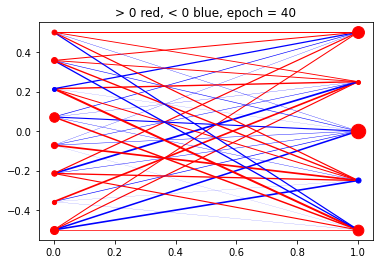

[[ 0.19495456 -0.46697785 -0.34558514  0.34767196  0.34693044]
 [ 0.08606386 -0.18921522 -0.28430935  0.60342042  0.04781943]
 [ 0.33092848  0.31104344 -0.17602711 -0.61814143  0.3024433 ]
 [-0.06261553  0.61452349 -0.36199206 -0.19169699 -0.05298481]
 [ 0.58242878 -0.12721645 -0.40571302 -0.09137388 -0.15932578]
 [ 0.60047256  0.45553736 -0.12754457  0.37745305 -0.3731204 ]
 [-0.46905854  0.23496466 -0.24496751  0.21978199  0.34323819]
 [-0.43035749  0.32123724 -0.20572029  0.24576487  0.4620205 ]] [ 0.22632652  0.07229139  0.15602436  0.32064294  0.27831214 -0.01741489
  0.19146124  0.11880916] [ 0.70178185 -0.04290496  1.04363826  0.08005027  0.54826478] 45.0 5.0


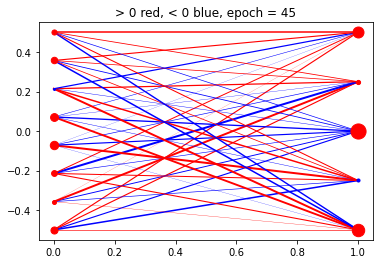

[[ 0.26023005 -0.52563259 -0.37322421  0.29616033  0.33614185]
 [-0.06551356 -0.20954878 -0.36328394  0.61088519 -0.06258433]
 [ 0.26248289  0.45711826 -0.21110469 -0.41550786  0.2951975 ]
 [-0.10508065  0.50525701 -0.43921198 -0.19984844 -0.1205198 ]
 [ 0.58298846 -0.15372975 -0.42480879 -0.18766977 -0.17124527]
 [ 0.71202091  0.38364402 -0.22379492  0.51710792 -0.50355758]
 [-0.56209495  0.32014679 -0.26580966  0.27297755  0.33721961]
 [-0.52219614  0.30580425 -0.21265541  0.32502101  0.32066014]] [0.21529484 0.24009191 0.22640027 0.3986399  0.34222805 0.03646025
 0.29530213 0.21035921] [ 0.60023512 -0.0926364   1.17810543  0.02593656  0.57180401] 50.0 5.0


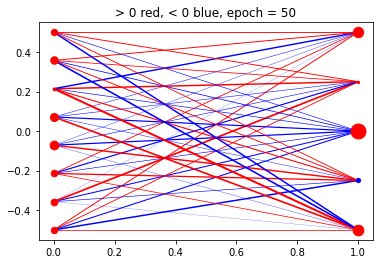

In [22]:
N, L, vmin, GAP, v_original, v0, v = load_data_01(q = 0.2, states = 6, PRINTING=True, SPINS=True)

M = 5

(x1, y1) = create_coord(L, 0) #visible units
(x2, y2) = create_coord(M, 1) #hidden units

v = v.astype(float)
vmin = float(vmin)
a, b, w, w_plot, a_plot, b_plot, epoch_plot, M_plot = RBM_train_jit(vmin, GAP, N, L, M, v, PRINTING=True)

for i in range(w_plot.shape[0]):
    print(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])
    plotgraph(w_plot[i], a_plot[i], b_plot[i], epoch_plot[i], M_plot[i])

## Plotting score for a range of values of $M$ and $beta$, SPIN = True, $q = 0.2$

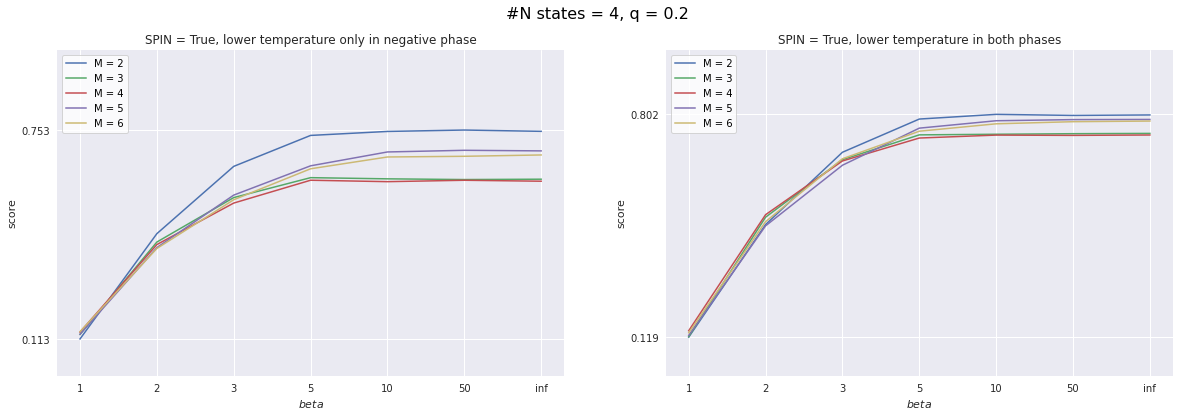

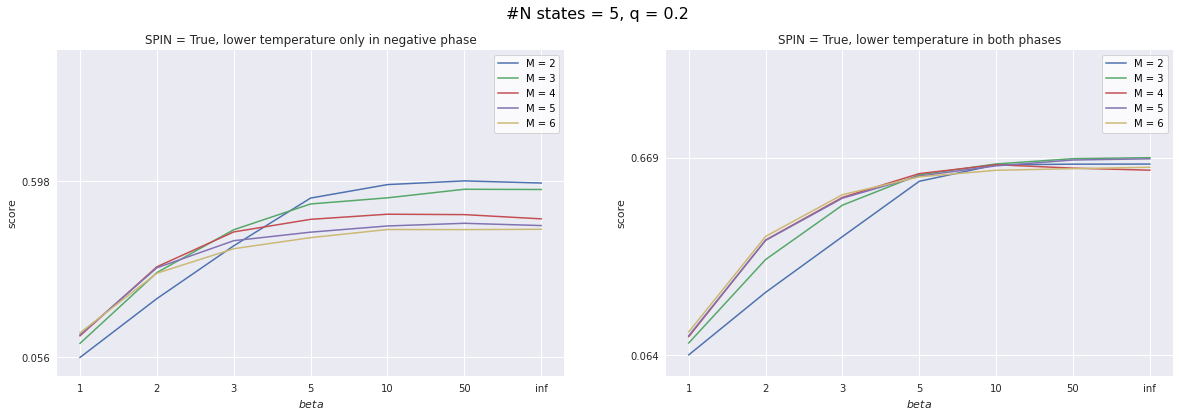

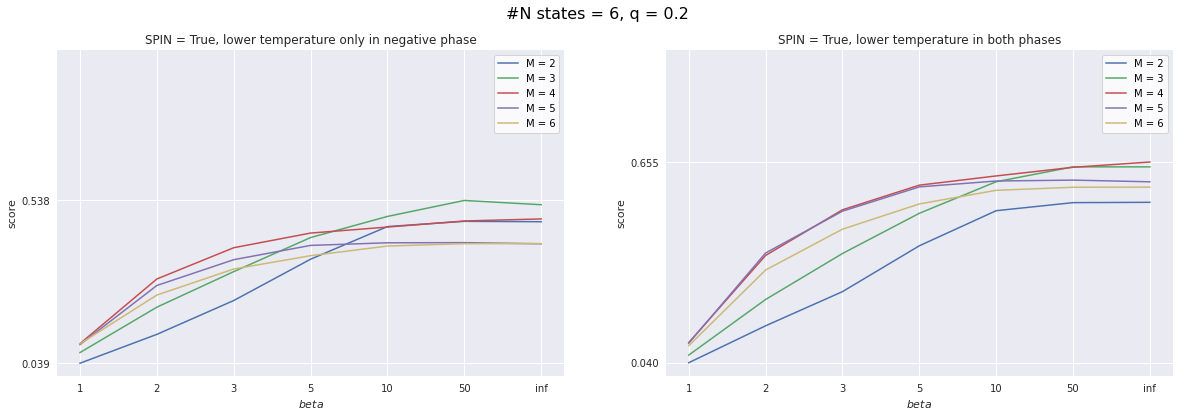

In [23]:
for state in (4, 5, 6):
    plot_scores_M(q=0.2, states=state)

### Trying with gaussian weights initialization with mean = 0, std =  $\frac{2}{\sqrt{N_{visible\_layers} + N_{hidden\_layers}}}$  for $q$ = 0.2

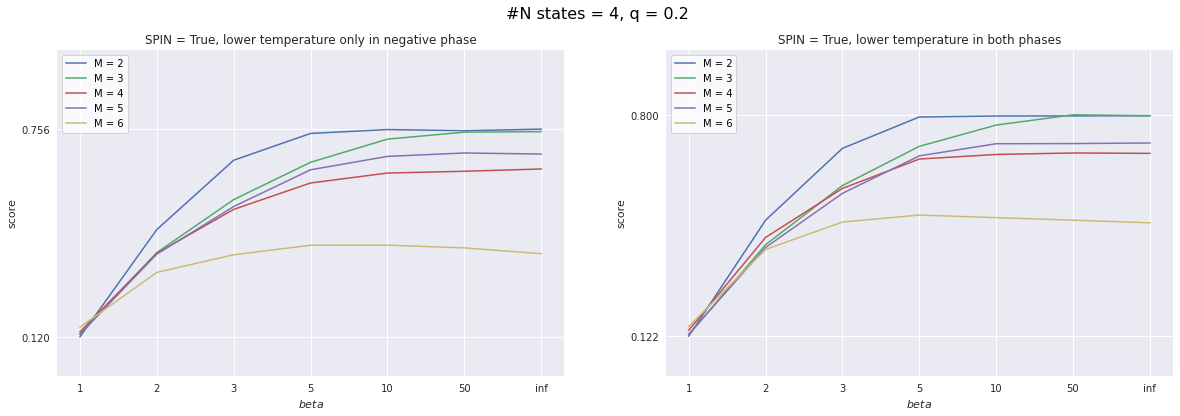

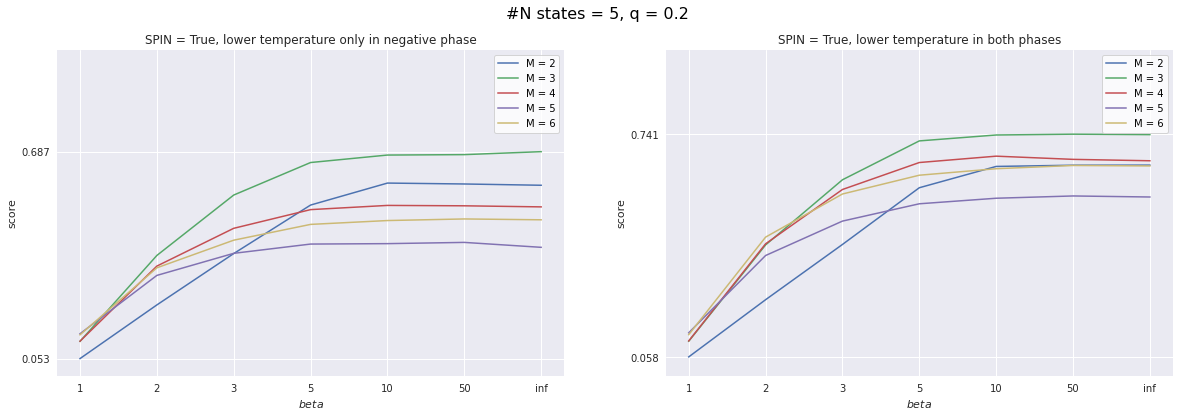

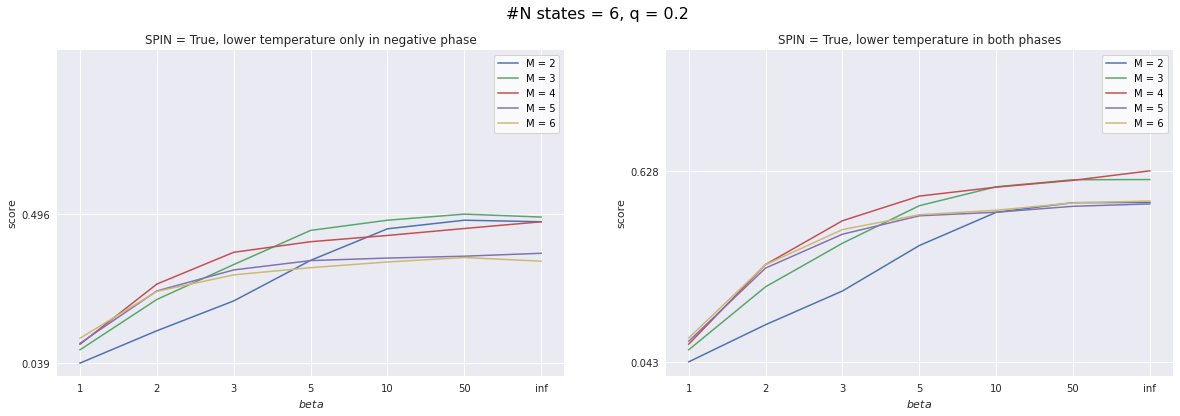

In [13]:
for state in (4, 5, 6):
    plot_scores_M_gauss(q=0.2, states=state)

# 5.1 Plotting score for a range of values of $M$ and $beta$, SPINS = False, $q = 0.1$

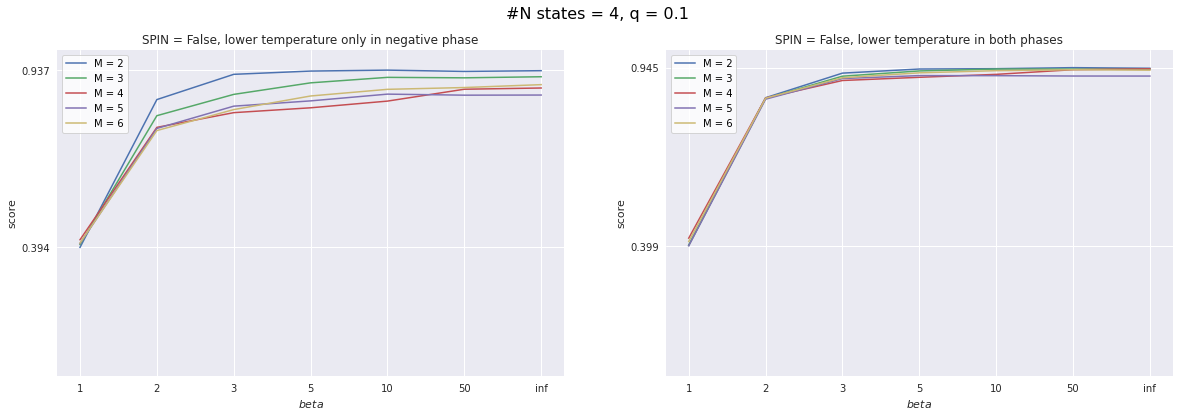

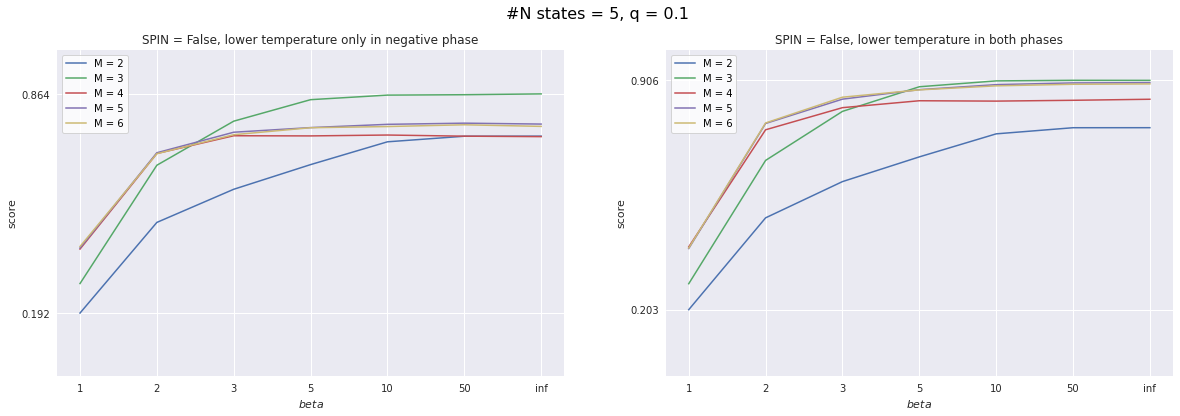

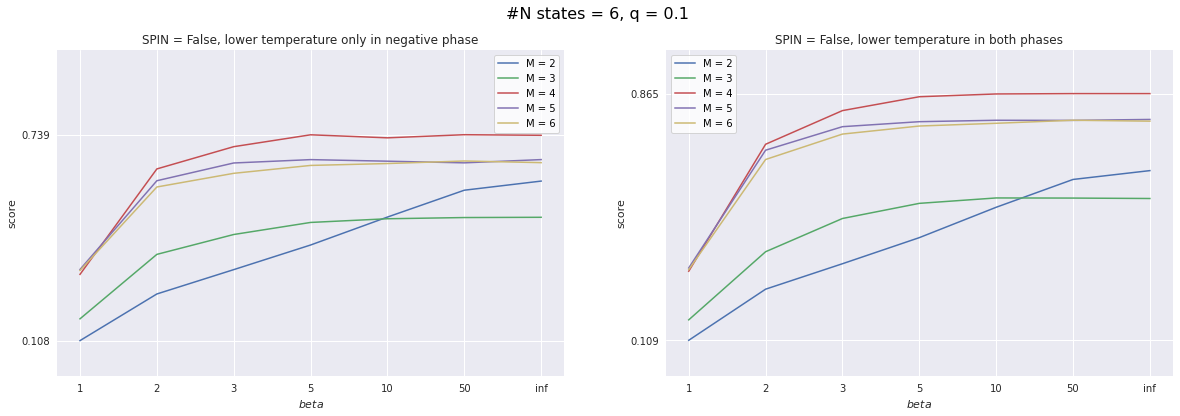

In [24]:
for state in (4, 5, 6):
    plot_scores_M(q=0.1, states=state, SPINS=False)

# 5.2 Plotting score for a range of values of $M$ and $beta$, SPINS = False, $q = 0.2$

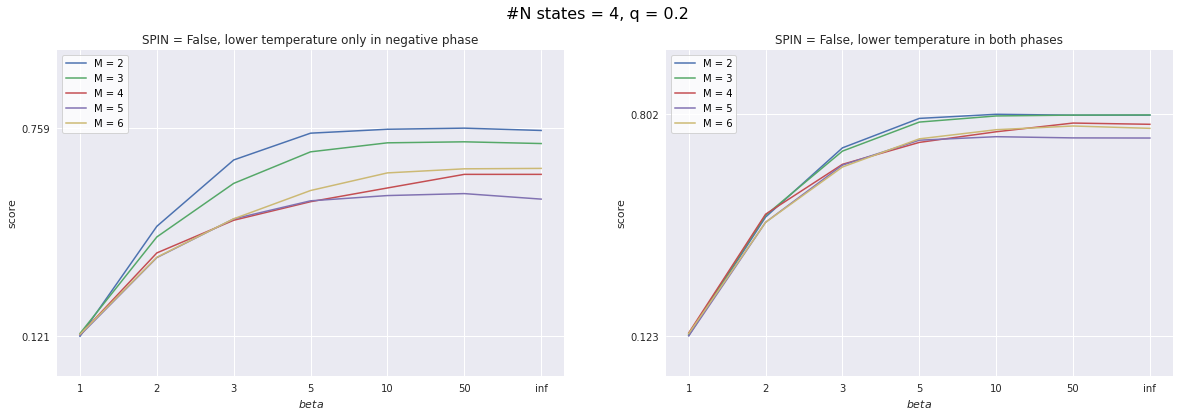

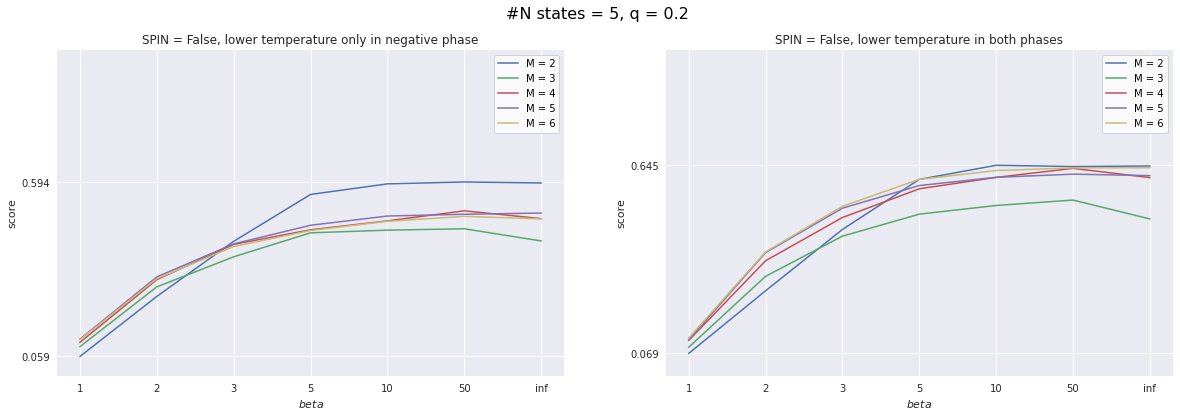

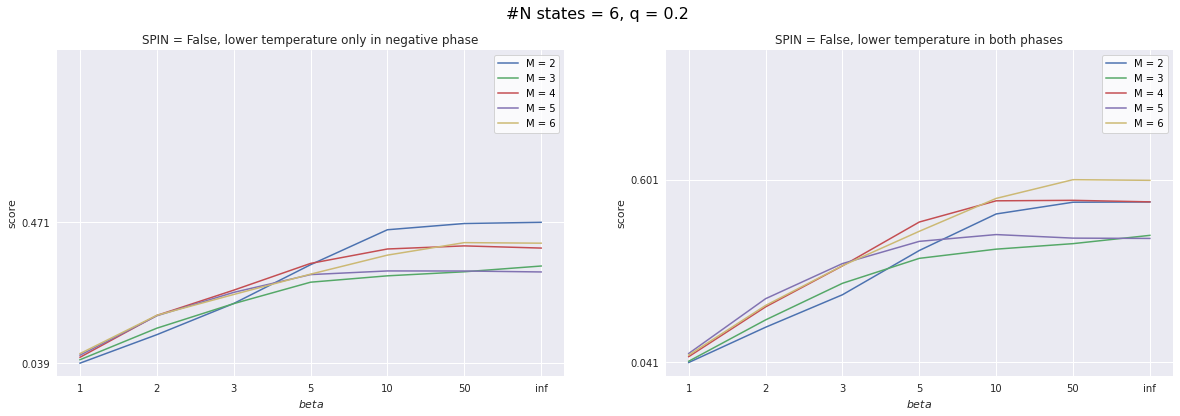

In [25]:
for state in (4, 5, 6):
    plot_scores_M(q=0.2, states=state, SPINS=False)

### Trying with gaussian weights initialization with mean = 0, std =  $\frac{2}{\sqrt{N_{visible\_layers} + N_{hidden\_layers}}}$  for $q$ = 0.2

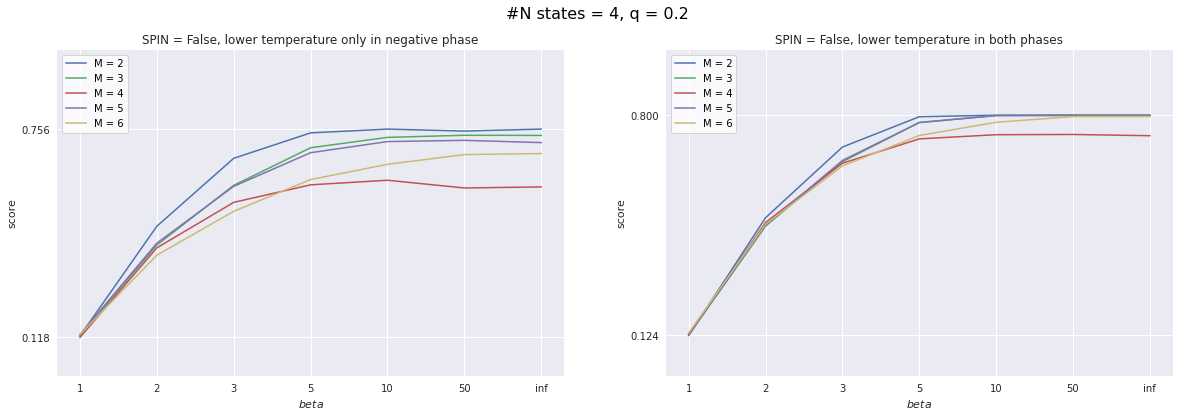

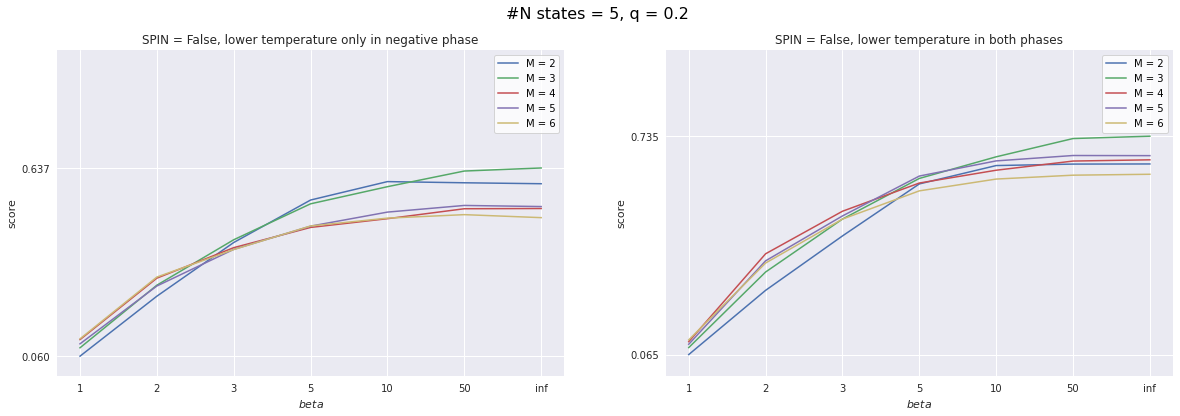

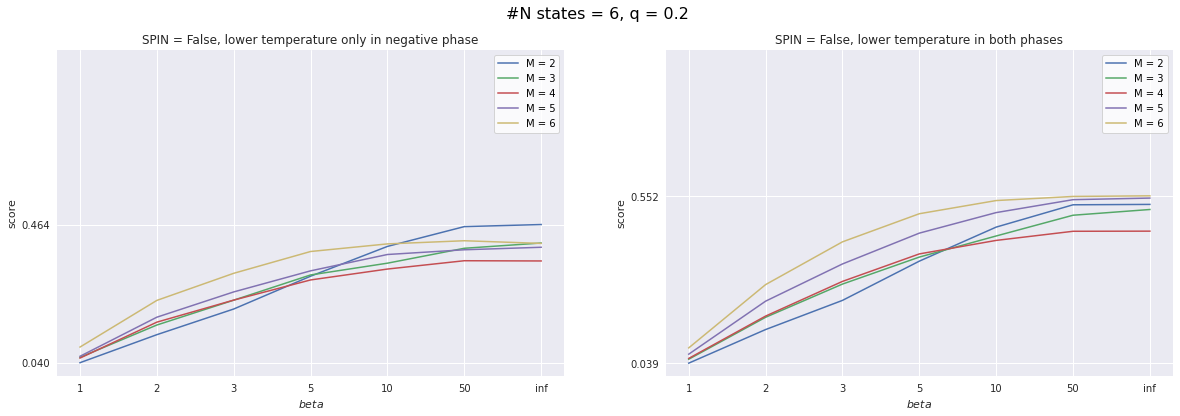

In [14]:
for state in (4, 5, 6):
    plot_scores_M_gauss(q=0.2, states=state, SPINS=False)

# 5.3 Plotting only best M

In [26]:
M_q1_spinTrue = (2, 4, 4)
M_q2_spinTrue = (2, 4, 4)
M_q1_spinFalse = (2, 4, 4)
M_q2_spinFalse = (2, 4, 4)

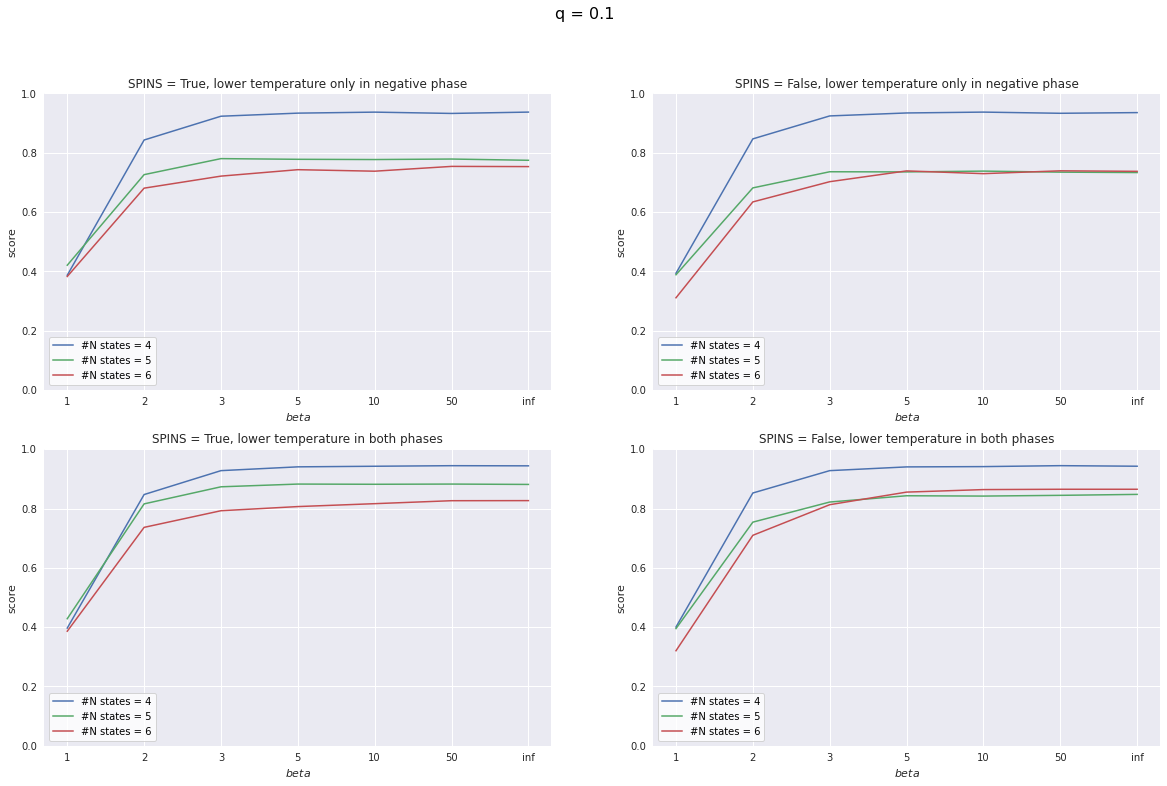

In [27]:
plot_best_M(0.1)

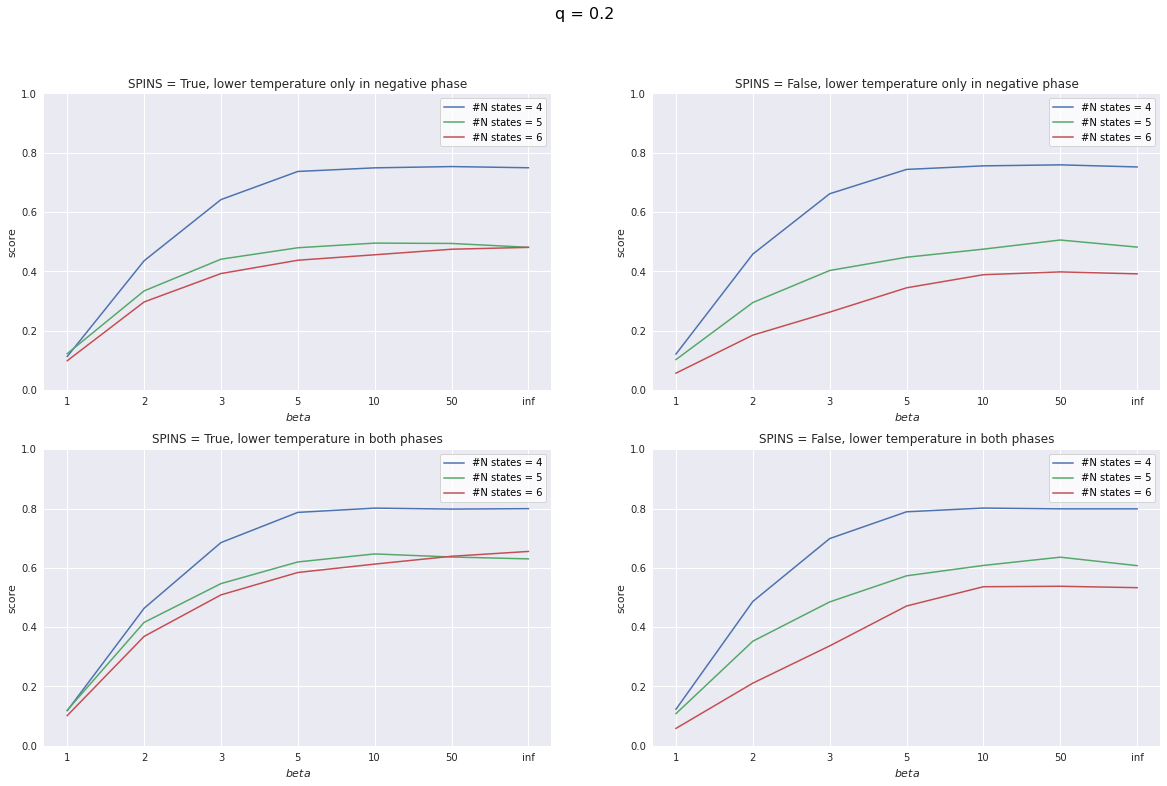

In [28]:
plot_best_M(0.2)

# 5.4 Comparison of the convergence of the RBM parameters for the case SPINS = True and SPINS = False <a name="5"></a>

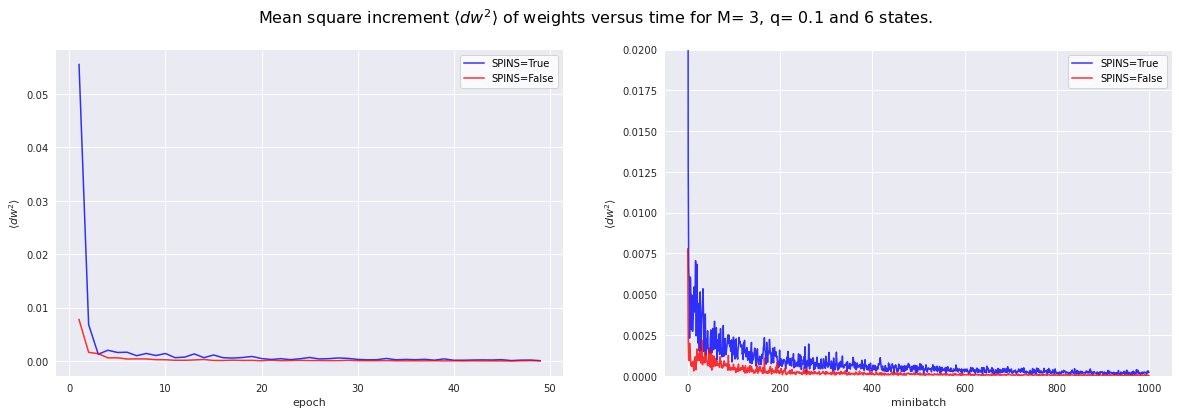

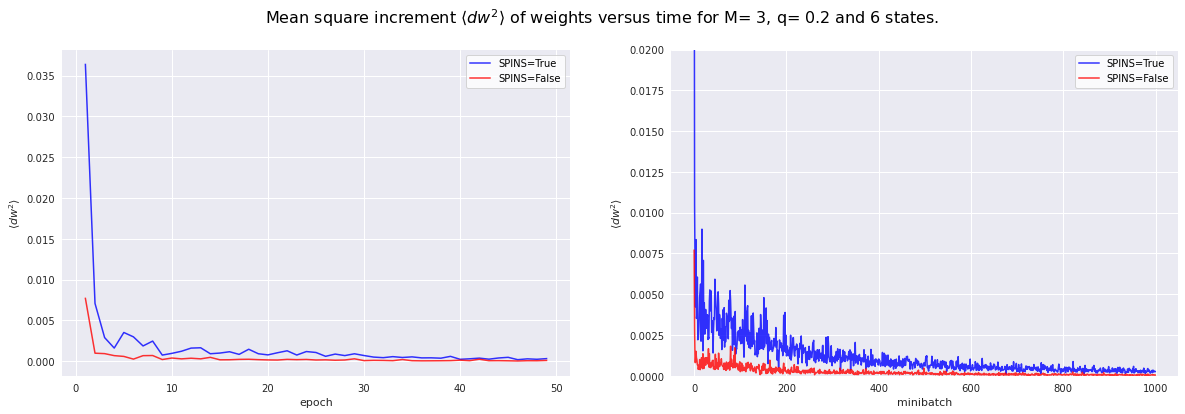

In [29]:
q = 0.1
states=6
M=3
plot_dw2(q,M,states)
q = 0.2
plot_dw2(q,M,states)

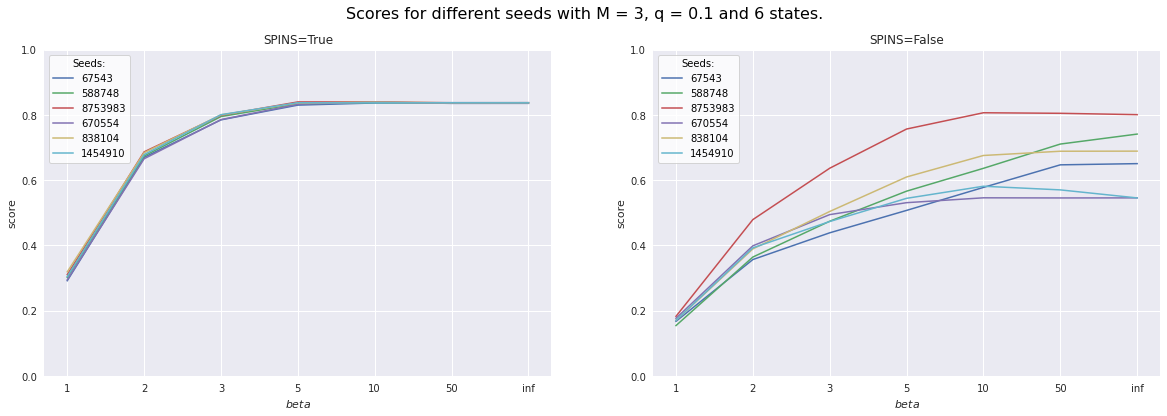

In [30]:
q = 0.1
states=6
M=3
plot_dseed(q,M,states)